In [2]:
# Importing the necessary libraries for the project. 
import pandas as pd 
import yfinance as yf
import numpy as np # for numerical operations
import seaborn as sns #visualisation
import matplotlib.pyplot as plt # visualization
%matplotlib inline 
import matplotlib.ticker as ticker # Library to customize ticks
from datetime import date
import matplotlib.dates as mdates
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from math import sqrt
# ParameterSampler for randomized hyperparameter sampling, optimizing model parameters in cross-validation.
from sklearn.model_selection import ParameterSampler
# pmdarima's auto_arima for automated selection of the best ARIMA parameters based on AIC/BIC scores.
from pmdarima import auto_arima
# TimeSeriesSplit for cross-validation with time series data to preserve the temporal ordering of data.
from sklearn.model_selection import TimeSeriesSplit, ParameterGrid
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
# Mean Squared Error and Mean Absolute Error metrics from sklearn for evaluating model accuracy.
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterSampler
from tensorflow.keras.optimizers import Adam
from keras.layers import BatchNormalization, Dropout, Dense, LSTM, GRU
import random
import optuna
from optuna.samplers import TPESampler
from keras_tuner import BayesianOptimization

import warnings # filter warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the dataset after the Log Returns transformation.
df1 = pd.read_csv('df1.csv', index_col=0, parse_dates=True)

# Along with the importation, the code will set the date as the index, value of 0 because is the first column.
## Setting parse_dates=true to ensure the dates are in datetime, making more appropriate for ML models.

In [4]:
df1.head()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
Date,,,,,,
2004-04-01,0.012635,0.031461,-0.023861,0.003674,0.000735,117.596902
2004-04-08,-0.010896,0.012635,-0.000125,0.000981,-0.001424,117.741650
2004-04-15,-0.003623,-0.010896,-0.029274,0.007394,-0.000325,0.776477
2004-04-22,-0.001496,-0.003623,0.031461,-0.000845,-0.000305,0.623353
2004-04-29,-0.000784,-0.001496,0.012635,-0.004200,-0.002649,0.647610


In [5]:
df1.describe()

,Close,lag_1,lag_4,rolling_mean_4w,rolling_mean_12w,volatility_4w
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,0.001575,0.001608,0.001508,0.001578,0.001516,7.731465
std,0.020723,0.020744,0.020750,0.009796,0.005364,23.505939
min,-0.069935,-0.069935,-0.069935,-0.051352,-0.026288,0.154122
25%,-0.007633,-0.007633,-0.007858,-0.003032,-0.001013,1.538535
50%,0.003635,0.003666,0.003626,0.002937,0.002346,2.585030
75%,0.013568,0.013643,0.013514,0.007596,0.004979,6.157669
max,0.051947,0.051947,0.051947,0.031089,0.019145,338.128664


In [6]:
# Define the selected exogenous variables
ex1 = df1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']]

In [7]:
# Define the split index for the train-test split (85% train, 15% test)
split_index = int(0.85 * len(df1))

# Target variable split
train = df1['Close'][:split_index]
test = df1['Close'][split_index:]

# Exogenous variables split
exo_train = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][:split_index]
exo_test = ex1[['rolling_mean_4w', 'rolling_mean_12w', 'volatility_4w', 'lag_1', 'lag_4']][split_index:]

## model - order=(1, 0, 3), seasonal_order=(1, 0, 2, 52) 
- p/d/q order extracted from the best parameters from the SARIMAX notebook.
- The parameters are the same as the baseline model (Best accuracy metrics across 4 different seasonalities).

                                        SARIMAX Results                                        
Dep. Variable:                                   Close   No. Observations:                  876
Model:             SARIMAX(1, 0, 3)x(1, 0, [1, 2], 52)   Log Likelihood                2537.512
Date:                                 Fri, 06 Dec 2024   AIC                          -5049.025
Time:                                         12:50:06   BIC                          -4986.945
Sample:                                     04-01-2004   HQIC                         -5025.279
                                          - 01-07-2021                                         
Covariance Type:                                   opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
rolling_mean_4w      1.4156      0.097     14.645      0.000  

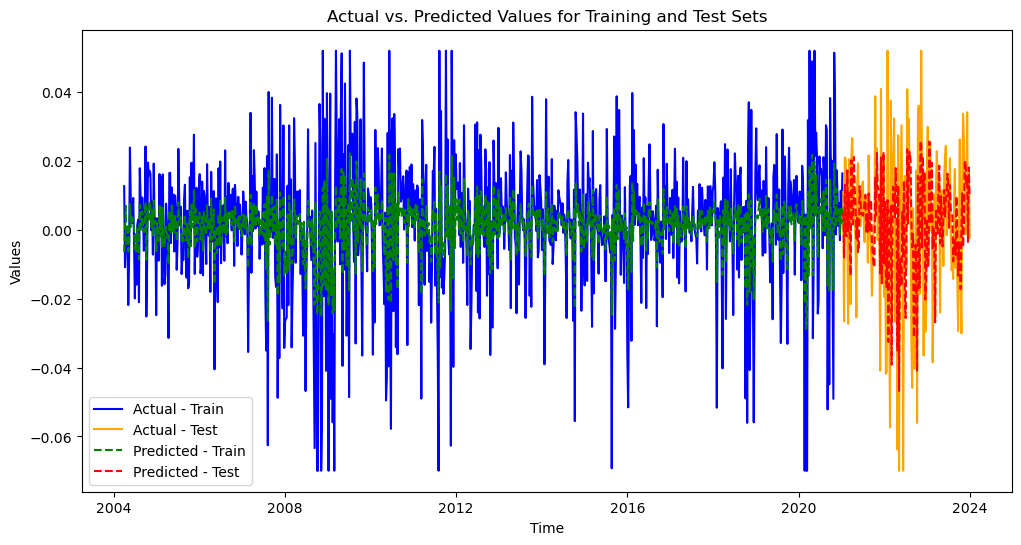

In [9]:
# Define SARIMAX model.
sarimax_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train)
sarimax_final_52 = sarimax_model.fit(disp=False)

# Print summary.
print(sarimax_final_52.summary())

# Calculate RMSE on training data.
train_predictions = sarimax_final_52.predict(start=0, end=len(train)-1, exog=exo_train)
train_rmse = mean_squared_error(train, train_predictions, squared=False)

# Calculate MAE on training data.
train_mae = mean_absolute_error(train, train_predictions)

# Calculate RMSE on test data.
test_predictions = sarimax_final_52.forecast(steps=len(test), exog=exo_test)
test_rmse = mean_squared_error(test, test_predictions, squared=False)

# Calculate MAE on test data.
test_mae = mean_absolute_error(test, test_predictions)

# Calculate Directional Accuracy on Training Data.
train_direction_accuracy = np.mean(
    np.sign(train_predictions[:-1] - train_predictions[1:]) == np.sign(train[:-1] - train[1:]))

# Calculate Directional Accuracy on Test Data.
test_direction_accuracy = np.mean(
    np.sign(test_predictions[:-1] - test_predictions[1:]) == np.sign(test[:-1] - test[1:]))

# Print evaluation metrics.
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_direction_accuracy * 100:.2f}%")
print(f"Directional Accuracy on Test Data: {test_direction_accuracy * 100:.2f}%")

# Plot the actual vs. predicted values for training and test sets.
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Actual - Train", color='blue')
plt.plot(test.index, test, label="Actual - Test", color='orange')

# Plot predictions on training and test set.
plt.plot(train.index, train_predictions, label="Predicted - Train", linestyle='--', color='green')
plt.plot(test.index, test_predictions, label="Predicted - Test", linestyle='--', color='red')

# Finalize the plot.
plt.legend()
plt.title("Actual vs. Predicted Values for Training and Test Sets")
plt.xlabel("Time")
plt.ylabel("Values")
plt.show()

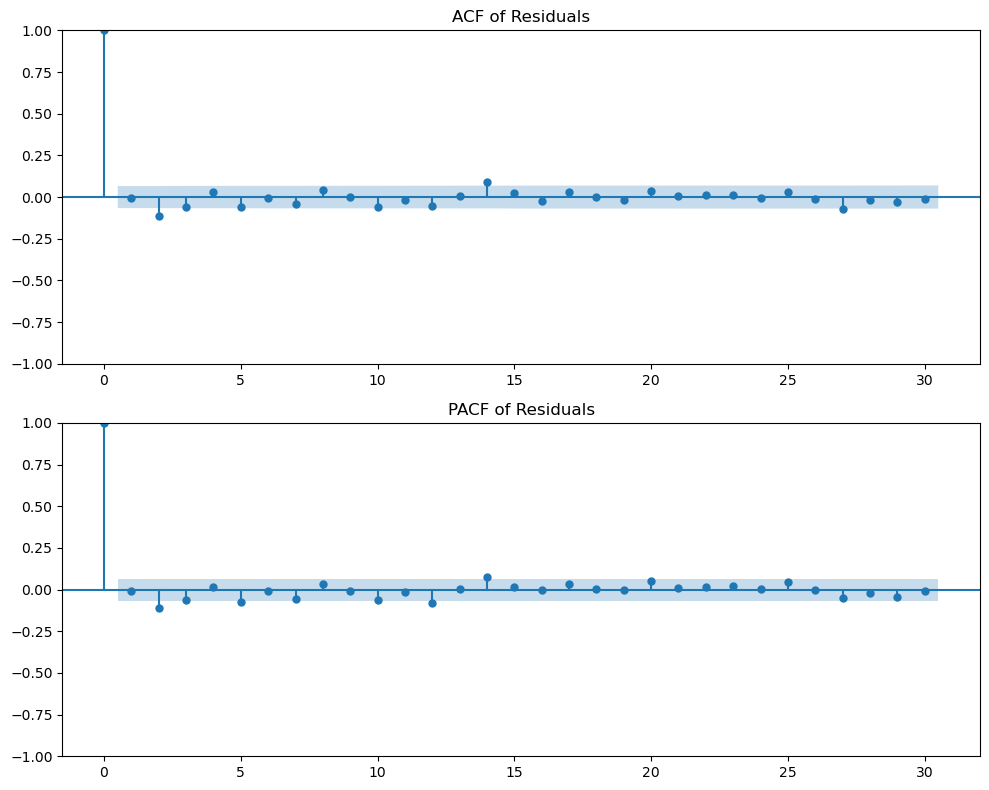

In [10]:
# Calculate residuals from the fitted model.
residuals_52 = sarimax_final_52.resid

# Plot ACF and PACF for residuals.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
sm.graphics.tsa.plot_acf(residuals_52, lags=30, ax=ax[0])
ax[0].set_title('ACF of Residuals')
sm.graphics.tsa.plot_pacf(residuals_52, lags=30, ax=ax[1])
ax[1].set_title('PACF of Residuals')
plt.tight_layout()
plt.show()

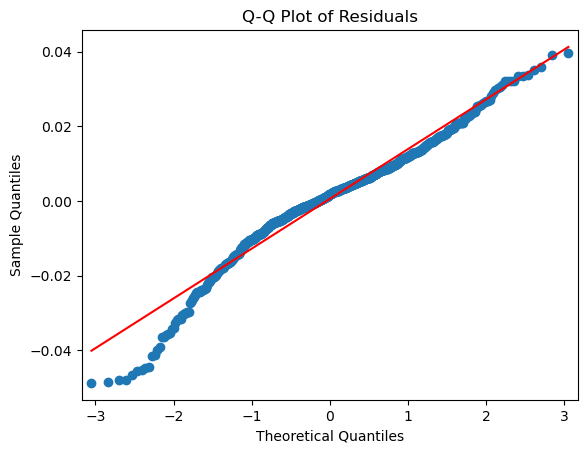

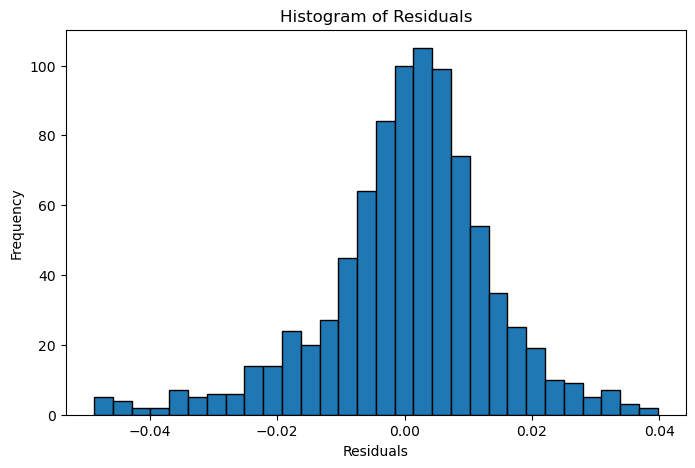

In [11]:
# Q-Q plot for normality check.
sm.qqplot(residuals_52, line='s')
plt.title('Q-Q Plot of Residuals')
plt.show()

# Histogram of residuals.
plt.figure(figsize=(8, 5))
plt.hist(residuals_52, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

In [12]:
# Ljung-Box test for autocorrelation.
ljung_box_results = acorr_ljungbox(residuals_52, lags=[10, 20, 30], return_df=True)
print(ljung_box_results) # prints the results.

# Arch test for heteroscedasticity 
arch_test_stat, arch_pvalue, _, _ = het_arch(residuals_52)
print("ARCH Test p-value:", arch_pvalue) # prints the arch results

      lb_stat  lb_pvalue
10  24.333845   0.006762
20  37.871745   0.009181
30  44.706827   0.041094
ARCH Test p-value: 7.96929136614076e-24


In [13]:
residuals_52.describe()

count    876.000000
mean       0.000569
std        0.013350
min       -0.048768
25%       -0.005453
50%        0.001800
75%        0.008253
max        0.039730
dtype: float64

In [14]:
print(f"Length of train: {len(train)}")
print(f"Length of residuals_52: {len(residuals_52)}")

Length of train: 876
Length of residuals_52: 876


In [15]:
# Test residuals: Actual test values - SARIMAX test predictions
test_residuals = test - test_predictions

# Check lengths to ensure alignment
print(f"Length of test_residuals: {len(test_residuals)}")

Length of test_residuals: 155


In [16]:
test_residuals.describe()

count    155.000000
mean       0.000062
std        0.019189
min       -0.061776
25%       -0.011712
50%       -0.000744
75%        0.011773
max        0.046612
dtype: float64

- PREPING THE RESIDUALS

In [18]:
# Use SARIMAX residuals directly from the original train-test split
y_train = residuals_52  # Residuals are already from the SARIMAX training set
y_test = test_residuals  # Residuals for testing

# Scale residuals for LSTM
scaler = StandardScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))  # Scale entire train residuals

# Scale the test residuals (optional, depends on hybrid combination process)
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Print minimum and maximum values of the scaled data for verification
print("Scaled Training Residuals - Min:", y_train_scaled.min(), "Max:", y_train_scaled.max())
print("Scaled Test Residuals - Min:", y_test_scaled.min(), "Max:", y_test_scaled.max())

Scaled Training Residuals - Min: -3.697693886455195 Max: 2.935007888674015
Scaled Test Residuals - Min: -4.672597219616202 Max: 3.4508202260553507


## Sequence Length = 4

In [124]:
# Reshape residual data into sequences for LSTM.
sequence_length = 4  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")  
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")  
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")   

Reshaped X_train_seq shape: (872, 4, 1)
Reshaped y_train_seq shape: (872, 1)
Reshaped X_test_seq shape: (151, 4, 1)
Reshaped y_test_seq shape: (151, 1)


### Random Search with Optuna

In [21]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-12-02 19:23:29,030] A new study created in memory with name: no-name-8d26949e-2375-4b50-9b51-4e71e179e0c9
[I 2024-12-02 19:24:19,885] Trial 0 finished with value: 2.2677390575408936 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.2677390575408936.
[I 2024-12-02 19:24:41,985] Trial 1 finished with value: 4.196542739868164 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.2677390575408936.
[I 2024-12-02 19:25:24,709] Trial 2 finished with value: 4.5543107986450195 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.0205341548879719, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-06, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 200, 'batch_size': 120}
Best validation loss: 1.588822841644287


In [37]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0005,
    'l2_lambda': 0.0205341548879719,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.4652 - val_loss: 1.8695
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2823 - val_loss: 1.8592
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2480 - val_loss: 1.8631
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3245 - val_loss: 1.8639
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2438 - val_loss: 1.8509
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2607 - val_loss: 1.8643
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1642 - val_loss: 1.8544
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2369 - val_loss: 1.8436
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2397 - val_loss: 1.8491
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1723 - val_loss: 1.8439
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1368 - val_loss: 1.8491
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1146 - val_loss: 1.8491


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
LSTM Model Performance:
Training RMSE: 0.013238783084573083
Test RMSE: 0.018191873889527695
Training MAE: 0.009719220079223313
Test MAE: 0.014088592461140916
Directional Accuracy on Training Data: 57.06084959816303%
Directional Accuracy on Test Data: 66.66666666666666%


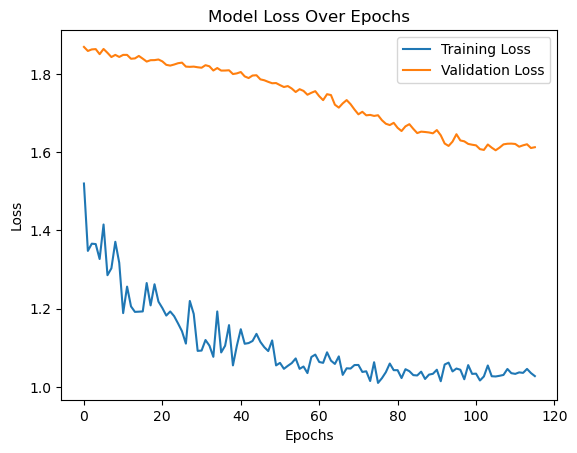

In [38]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [39]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 08s]
val_loss: 1.9128773212432861

Best val_loss So Far: 1.8724615573883057
Total elapsed time: 00h 06m 46s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.1, l2_lambda=0.1, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=5.0, units=32, num_layers=1, batch_size=120
Best hyperparameters for LSTM: {'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'l2_lambda': 0.1, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 5.0, 'units': 32, 'num_layers': 1, 'batch_size': 120}
Best batch size for LSTM: 120


In [47]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.9582 - val_loss: 2.0364
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6794 - val_loss: 2.0185
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5330 - val_loss: 2.0069
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5685 - val_loss: 1.9987
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4218 - val_loss: 1.9924
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4173 - val_loss: 1.9871
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4576 - val_loss: 1.9813
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3497 - val_loss: 1.9761
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4042 - val_loss: 1.9698
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2948 - val_loss: 1.9623
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2460 - val_loss: 1.9551
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3070 - val_loss: 1.9485


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
LSTM Model Performance:
Training RMSE: 0.013262497938806999
Test RMSE: 0.018138131855282846
Training MAE: 0.009734542476069063
Test MAE: 0.014027141204695339
Directional Accuracy on Training Data: 55.33869115958668%
Directional Accuracy on Test Data: 66.66666666666666%


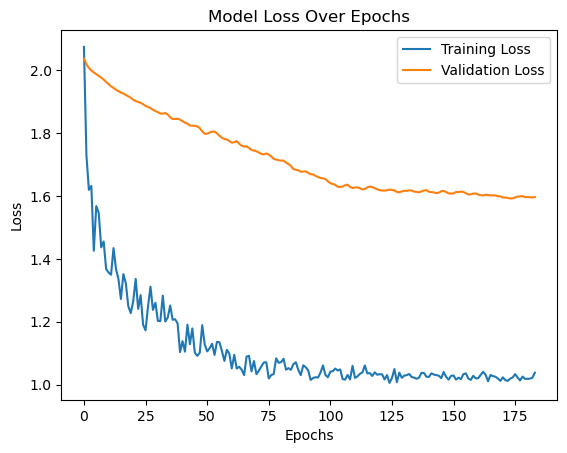

In [49]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [29]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.2984740734100342
Final Validation Loss: 2.0644750595092773
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.7077150344848633
Final Validation Loss: 2.4220213890075684
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.7984168529510498
Final Validation Loss: 2.1420044898986816
Running combination 

In [67]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2.8840 - val_loss: 2.1076
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0940 - val_loss: 2.1248
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8467 - val_loss: 2.1301
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8938 - val_loss: 2.1112
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7912 - val_loss: 2.1049
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.8357 - val_loss: 2.1186
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5377 - val_loss: 2.1060
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.4894 - val_loss: 2.1280
Epoch 9/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2558 - val_loss: 2.1314
Epoch 10/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2883 - val_loss: 2.1478
Epoch 11/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3844 - val_loss: 2.1547
Epoch 12/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.013206066284622826
Test RMSE: 0.01862978696544213
Training MAE: 0.009692748252649984
Test MAE: 0.014498814541132016
Directional Accuracy on Training Data: 63.605051664753155%
Directional Accuracy on Test Data: 67.33333333333333%


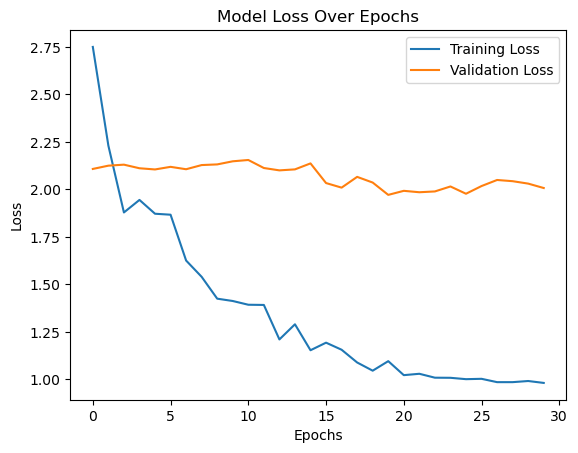

In [68]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [33]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.0038278102874756
Final Validation Loss: 2.01945161819458
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.07640266418457
Final Validation Loss: 4.633448123931885
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.974932909011841
Final Validation

In [126]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 12.6895 - val_loss: 11.5091
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.0218 - val_loss: 10.5196
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.9553 - val_loss: 9.5747
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9510 - val_loss: 8.6758
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9175 - val_loss: 7.8775
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0298 - val_loss: 7.1902
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2805 - val_loss: 6.5911
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7751 - val_loss: 6.1033
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3922 - val_loss: 5.6734
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8470 - val_loss: 5.2887
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4203 - val_loss: 4.9539
Epoch 12/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM Model Performance:
Training RMSE: 0.013356581744514043
Test RMSE: 0.01848996445252827
Training MAE: 0.00974690209968477
Test MAE: 0.014106352994058935
Directional Accuracy on Training Data: 65.097588978186%
Directional Accuracy on Test Data: 69.33333333333334%


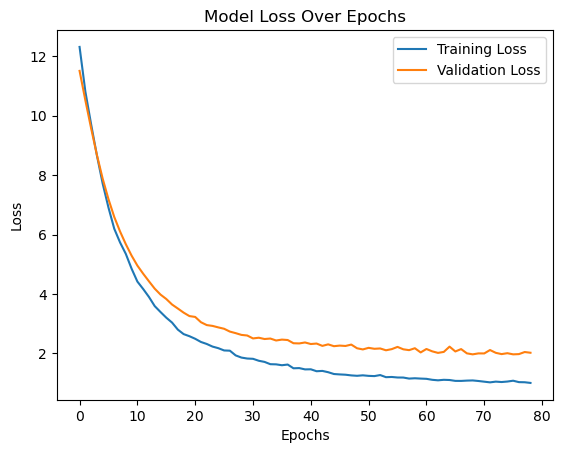

In [128]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [130]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation losses using the `scaler`
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler.scale_[0] + scaler.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler.scale_[0] + scaler.mean_[0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.0139369187069917
Descaled Validation Loss: 0.01952965044734505


### Evaluation of models tested with different architectures derived from different hyper-parameter tunning approaches. 

### Residuals LSTM Model Performance Comparison for SL = 4

| Metric                | Random Search (Optuna) | Keras Tuner          | Random Search (2 Layers) | Random Search (3 Layers) |
|------------------------|-------------------------|----------------------|--------------------------|--------------------------|
| **Train RMSE**        | 0.013238783084573083   | 0.013262497938806999 | 0.013206066284622826     | 0.013356581744514043     |
| **Test RMSE**         | 0.018191873889527695   | 0.018138131855282846 | 0.01862978696544213      | 0.01848996445252827      |
| **Train MAE**         | 0.009719220079223313   | 0.009734542476069063 | 0.009692748252649984     | 0.00974690209968477      |
| **Test MAE**          | 0.014088592461140916   | 0.014027141204695339 | 0.014498814541132016     | 0.014106352994058935     |
| **Train Loss**        | 1.0275673866271973     | 1.038259506225586    | 0.9818540811538696       | 1.0038278102874756       |
| **Validation Loss**   | 1.6129875183105469     | 1.5963395833969116   | 2.007214307785034        | 2.01945161819458         |
| **Train DA**          | 57.06%                 | 55.34%               | 63.61%                   | 65.10%                   |
| **Test DA**           | 66.67%                 | 66.67%               | 67.33%                   | 69.33%                   |
   
- According to the metrics table, the Model Random Search (3 Layers) did not had the lowest RMSE and MAE metrics, however by observing and train and val loss plot, the model is the one that is less likely to overfit. In addition, as secondary metric, the DA is the highest among the models.

### Cross Validation of the best model with SL of 4 with Descaled Metrics. 

- Training and Validation Loss
| **Metric**           | **Loss**       |
|-----------------------|----------------|
| **Training Loss**     | 0.01393692     |
| **Validation Loss**   | 0.01952965     |

- TSCV RMSE Values
| **Fold** | **RMSE**        |
|----------|-----------------|
| Fold 1   | 0.01891854      |
| Fold 2   | 0.01304871      |
| Fold 3   | 0.01124474      |
| Fold 4   | 0.01666118      |

**Average TSCV RMSE**: **0.01496829**

- The type of cross validation where the train data is added throughout folds, the scores shows that the model improves each time the fold is increased. However, it performs above average in the last fold.   

- FRWCV RMSE Values
| **Window** | **RMSE**       |
|------------|----------------|
| Window 1   | 0.01610436     |
| Window 2   | 0.01132182     |
| Window 3   | 0.01130602     |
| Window 4   | 0.01038270     |
| Window 5   | 0.01240948     |

**Average FRWCV RMSE**: **0.01230488**

- The scores for the approach presented variability and it ranges from 0.01 to 0.016 and it shows that the model struggles at first window, but performs below average in other windows.

The time-series and fixed rolling window techniques uses different validation set-ups and the present model have averages that are close, suggesting robustness. And the avg of FRWCV being lower than the TSCV it suggests that the model performs better under rolling window cenario.  

In [98]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model
    
# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the initial model weights to reset after each fold
model = build_best_model(best_params)

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step
Fold 1 RMSE: 1.3752727849656896
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 2 RMSE: 0.9353432972190361
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Fold 3 RMSE: 0.8001399117941452
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 4 RMSE: 1.2060887683538701
Average RMSE from TSCV: 1.0792111905831852


In [99]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Rolling window RMSE: 1.1643571863613333
Rolling window starting at index 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Rolling window RMSE: 0.8059169210883157
Rolling window starting at index 200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Rolling window RMSE: 0.8047331264702186
Rolling window starting at index 300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Rolling window RMSE: 0.7355321968569235
Rolling window starting at index 400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Rolling window RMSE: 0.8874346721021341
Average Rolling Window RMSE: 0.8795948205757849


In [100]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.01891853949191251, 0.013048714858439963, 0.011244743575767189, 0.01666117658272334]
Descaled FRWCV RMSE Values: [0.01610436674206397, 0.011321824181653398, 0.011306029225862027, 0.01038270552827611, 0.012409486901006614]
Average Descaled TSCV RMSE: 0.01496829362721075
Average Descaled FRWCV RMSE: 0.012304882515772424


## Sequence Length = 12

In [196]:
# Reshape residual data into sequences for LSTM.
sequence_length = 12  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}")  
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}")  
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (864, 12, 1)
Reshaped y_train_seq shape: (864, 1)
Reshaped X_test_seq shape: (143, 12, 1)
Reshaped y_test_seq shape: (143, 1)


### Random Search with Optuna

In [44]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-12-02 20:14:11,740] A new study created in memory with name: no-name-ef030133-40e9-416a-9ac8-1546cbfcddd5
[I 2024-12-02 20:14:44,962] Trial 0 finished with value: 2.4012746810913086 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.4012746810913086.
[I 2024-12-02 20:15:12,410] Trial 1 finished with value: 4.217561721801758 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.4012746810913086.
[I 2024-12-02 20:16:26,739] Trial 2 finished with value: 4.278600692749023 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.1, 'l2_lambda': 0.028980866560207673, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-06, 'clipnorm': 1.0, 'units': 64, 'num_layers': 1, 'epochs': 200, 'batch_size': 120}
Best validation loss: 1.7392699718475342


In [135]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.0005,
    'l2_lambda': 0.028980866560207673,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 120
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.3451 - val_loss: 1.9773
Epoch 2/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2690 - val_loss: 1.9754
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3289 - val_loss: 1.9796
Epoch 4/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2609 - val_loss: 1.9754
Epoch 5/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4165 - val_loss: 1.9714
Epoch 6/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2580 - val_loss: 1.9726
Epoch 7/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3359 - val_loss: 1.9687
Epoch 8/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2778 - val_loss: 1.9682
Epoch 9/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2525 - val_loss: 1.9718
Epoch 10/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1907 - val_loss: 1.9723
Epoch 11/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.1761 - val_loss: 1.9695
Epoch 12/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1699 - val_loss: 1.9677

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
LSTM Model Performance:
Training RMSE: 0.013395511480996058
Test RMSE: 0.019276133909336714
Training MAE: 0.009657172670117108
Test MAE: 0.01511222770161961
Directional Accuracy on Training Data: 67.78679026651217%
Directional Accuracy on Test Data: 69.01408450704226%


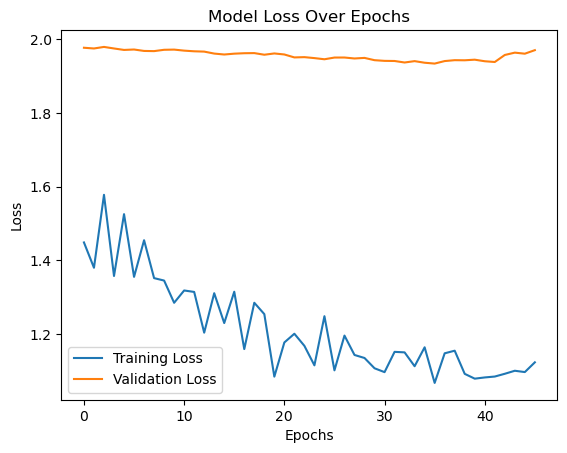

In [136]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [48]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 55s]
val_loss: 1.8431047201156616

Best val_loss So Far: 1.8431047201156616
Total elapsed time: 00h 19m 10s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.0960392293213717, learning_rate=0.001, learning_rate_decay=1e-05, clipnorm=1.0, units=128, num_layers=2, batch_size=32
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0960392293213717, 'learning_rate': 0.001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 128, 'num_layers': 2, 'batch_size': 32}
Best batch size for LSTM: 32


In [198]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.0960392293213717,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 21.2268 - val_loss: 15.0292
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 13.7909 - val_loss: 10.1554
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.2309 - val_loss: 7.1001
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6.2950 - val_loss: 5.3805
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6271 - val_loss: 4.2233
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4811 - val_loss: 3.5116
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7553 - val_loss: 3.1021
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.2686 - val_loss: 2.8221
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9716 - val_loss: 2.6540
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7572 - val_loss: 2.4954
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5503 - val_loss: 2.3822
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
LSTM Model Performance:
Training RMSE: 0.013553748266389451
Test RMSE: 0.018046680296372717
Training MAE: 0.009725744024432423
Test MAE: 0.013830640439155325
Directional Accuracy on Training Data: 69.98841251448435%
Directional Accuracy on Test Data: 71.83098591549296%


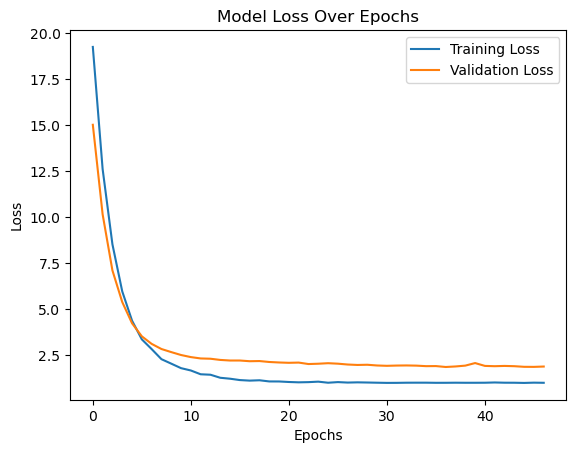

In [199]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [52]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.390604853630066
Final Validation Loss: 2.2589991092681885
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.6292046308517456
Final Validation Loss: 2.5098814964294434
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.7566055059432983
Final Validation Loss: 2.2728159427642822
Running combination 4

In [163]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.6516 - val_loss: 2.1595
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0447 - val_loss: 2.1623
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0697 - val_loss: 2.1622
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9304 - val_loss: 2.1762
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8331 - val_loss: 2.1754
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7864 - val_loss: 2.1656
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5283 - val_loss: 2.1413
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4949 - val_loss: 2.1891
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3897 - val_loss: 2.1580
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3211 - val_loss: 2.1488
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2962 - val_loss: 2.1150
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
LSTM Model Performance:
Training RMSE: 0.013414833751848378
Test RMSE: 0.018551249768389705
Training MAE: 0.009839735346328284
Test MAE: 0.014508465285706795
Directional Accuracy on Training Data: 59.907300115874854%
Directional Accuracy on Test Data: 59.859154929577464%


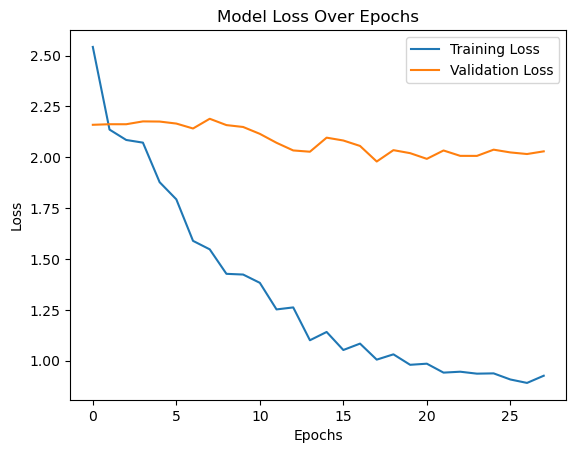

In [164]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [56]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.9970408082008362
Final Validation Loss: 2.046570301055908
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.010091304779053
Final Validation Loss: 4.661306858062744
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.8945770263671875
Final Validat

In [179]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 12.3886 - val_loss: 11.5814
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.0040 - val_loss: 10.6005
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.8368 - val_loss: 9.6772
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.8470 - val_loss: 8.8546
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.9520 - val_loss: 8.1075
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3381 - val_loss: 7.4416
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6034 - val_loss: 6.8691
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.9928 - val_loss: 6.3801
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.6193 - val_loss: 5.9394
Epoch 10/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.0579 - val_loss: 5.5484
Epoch 11/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.5621 - val_loss: 5.1755
Epoch 12/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
LSTM Model Performance:
Training RMSE: 0.015116780723681106
Test RMSE: 0.018460551810223918
Training MAE: 0.010540832237555512
Test MAE: 0.013941635343571542
Directional Accuracy on Training Data: 61.87717265353419%
Directional Accuracy on Test Data: 69.71830985915493%


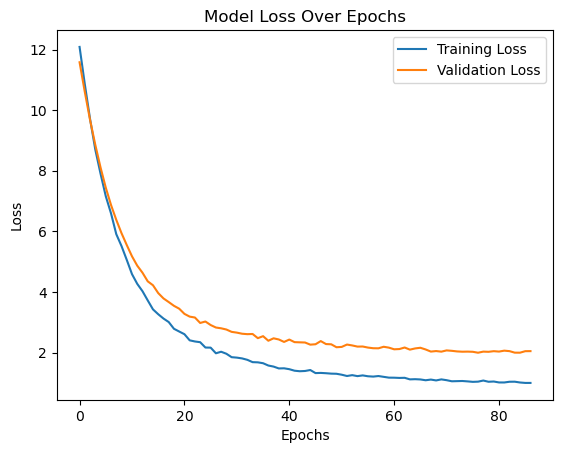

In [180]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [202]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation losses using the `scaler`
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler.scale_[0] + scaler.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler.scale_[0] + scaler.mean_[0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.013797114292059359
Descaled Validation Loss: 0.018804063361043597


### Model Performance Comparison (Sequence Length = 12)

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner** | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------|------------------------------|------------------------------|
| **Train RMSE**         | 0.013395511              | 0.013553748    | 0.013414834                  | 0.015116781                 |
| **Test RMSE**          | 0.019276134              | 0.018046680    | 0.018551250                  | 0.018460552                 |
| **Train MAE**          | 0.009657173              | 0.009725744    | 0.009839735                  | 0.010540832                 |
| **Test MAE**           | 0.015112228              | 0.013830640    | 0.014508465                  | 0.013941635                 |
| **Train Loss**         | 1.123186350              | 0.982941508    | 0.926418424                  | 0.997040808                 |
| **Validation Loss**    | 1.970798969              | 1.867849946    | 2.029031754                  | 2.046570301                 |
| **Train DA**           | 67.79%                   | 69.99%         | 59.91%                       | 61.88%                      |
| **Test DA**            | 69.01%                   | 71.83%         | 59.86%                       | 69.72%                      |


- With sequence length of 12, the model that outperformed the others was the architecture extracted from Keras Tuner, the model achieved the lowest scores for all metrics. In addition, its train and val loss suggests good convergence and not a significant gap between them. Thus, less prone to overfit.

### Cross Validation of best model with descaled metrics (SL = 12).

#### Training and Validation Loss.
| **Metric**           | **Loss**       |
|-----------------------|----------------|
| **Training Loss**     | 0.01379711     |
| **Validation Loss**   | 0.01880406     |

- If compare to the previous SL the model improved when the SL was increased to 12. 0.019529 to 0.0188040.

#### TSCV RMSE Values.
| **Fold** | **RMSE**        |
|----------|-----------------|
| Fold 1   | 0.01891142      |
| Fold 2   | 0.01297662      |
| Fold 3   | 0.01149948      |
| Fold 4   | 0.01556677      |

- Like the previous SL, the models fairly similar across the all folds, but it struggles in the first and the last.  

**Average TSCV RMSE**: **0.01473857**

#### FRWCV RMSE Values.
| **Window** | **RMSE**       |
|------------|----------------|
| Window 1   | 0.01681824     |
| Window 2   | 0.01127772     |
| Window 3   | 0.01217473     |
| Window 4   | 0.01004578     |
| Window 5   | 0.01323356     |

**Average FRWCV RMSE**: **0.01271000**

- The scores throughout the windows have similar behaviour as the TSCV, performing above average on the first and last window.

In [204]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'units2': 128,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.001,
    'l2_lambda': 0.0960392293213717,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model
# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the initial model weights to reset after each fold
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Fold 1 RMSE: 1.3747390217470548
Fold 2
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 2 RMSE: 0.9299403448833766
Fold 3
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Fold 3 RMSE: 0.819232090344689
Fold 4
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 4 RMSE: 1.1240657089049269
Average RMSE from TSCV: 1.0619942914700118


In [205]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rolling window RMSE: 1.2178602228825006
Rolling window starting at index 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Rolling window RMSE: 0.8026115476930928
Rolling window starting at index 200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Rolling window RMSE: 0.8698400915541388
Rolling window starting at index 300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Rolling window RMSE: 0.7102804878413091
Rolling window starting at index 400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Rolling window RMSE: 0.9491972290721635
Average Rolling Window RMSE: 0.909957915808641


In [206]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.0189114176767661, 0.012976625163166807, 0.011499483808200019, 0.015566771710405587]
Descaled FRWCV RMSE Values: [0.016818238965874498, 0.011277721745425533, 0.01217472859270309, 0.010045780844331094, 0.013233563005079245]
Average Descaled TSCV RMSE: 0.014738574589634628
Average Descaled FRWCV RMSE: 0.012710006630682691


## Sequence Length = 26

In [211]:
# Reshape residual data into sequences for LSTM.
sequence_length = 26  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (850, 26, 1)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 1)
Reshaped y_test_seq shape: (129, 1)


### Random Search with Optuna

In [67]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-12-02 21:14:56,425] A new study created in memory with name: no-name-aa81bc51-7f65-481a-bc69-2c7cd38d6470
[I 2024-12-02 21:15:38,598] Trial 0 finished with value: 2.0657098293304443 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.0657098293304443.
[I 2024-12-02 21:16:04,791] Trial 1 finished with value: 4.4277143478393555 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.0657098293304443.
[I 2024-12-02 21:18:13,918] Trial 2 finished with value: 4.673290252685547 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.02206627533246583, 'learning_rate': 0.001, 'learning_rate_decay': 0, 'clipnorm': 5.0, 'units': 128, 'num_layers': 1, 'epochs': 100, 'batch_size': 64}
Best validation loss: 1.3743788003921509


In [213]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.001,
    'l2_lambda': 0.02206627533246583,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.1422 - val_loss: 1.8171
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0954 - val_loss: 1.8202
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1633 - val_loss: 1.8205
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1653 - val_loss: 1.8169
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0526 - val_loss: 1.8105
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0014 - val_loss: 1.7907
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0926 - val_loss: 1.8028
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0255 - val_loss: 1.7869
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9844 - val_loss: 1.7804
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.0370 - val_loss: 1.8010
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9810 - val_loss: 1.7771
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.013968463891293848
Test RMSE: 0.019395004371295235
Training MAE: 0.010971596278647827
Test MAE: 0.014983125190852502
Directional Accuracy on Training Data: 69.72909305064782%
Directional Accuracy on Test Data: 71.875%


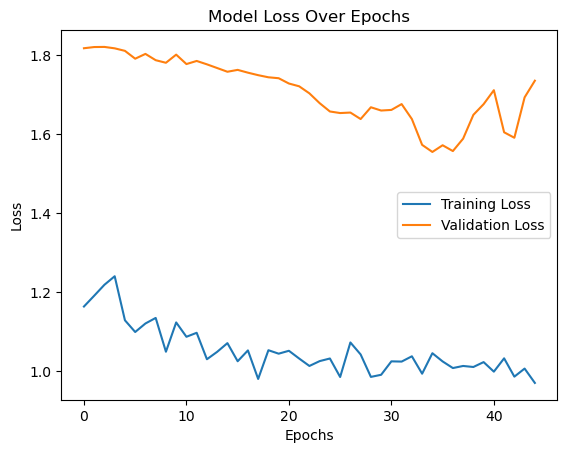

In [214]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [71]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 00m 28s]
val_loss: 1.6380908489227295

Best val_loss So Far: 1.6380908489227295
Total elapsed time: 00h 31m 18s
Built model with params: dropout_rate=0.3, recurrent_dropout=0.1, l2_lambda=0.1, learning_rate=0.0005, learning_rate_decay=1e-05, clipnorm=5.0, units=64, num_layers=1, batch_size=64
Best hyperparameters for LSTM: {'dropout_rate': 0.3, 'recurrent_dropout': 0.1, 'l2_lambda': 0.1, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 5.0, 'units': 64, 'num_layers': 1, 'batch_size': 64}
Best batch size for LSTM: 64


In [217]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.1,
    'epochs': 200,
    'dropout_rate': 0.3,
    'clipnorm': 5.0,
    'batch_size': 64
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.3930 - val_loss: 1.9659
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3642 - val_loss: 1.9611
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2089 - val_loss: 1.9468
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3618 - val_loss: 1.9333
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2867 - val_loss: 1.9240
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2902 - val_loss: 1.9147
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2261 - val_loss: 1.9042
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1193 - val_loss: 1.8984
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1367 - val_loss: 1.8845
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1760 - val_loss: 1.8812
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1336 - val_loss: 1.8798
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
LSTM Model Performance:
Training RMSE: 0.01554602483070244
Test RMSE: 0.02013202860716311
Training MAE: 0.012908761923734791
Test MAE: 0.01581713893439403
Directional Accuracy on Training Data: 67.962308598351%
Directional Accuracy on Test Data: 70.3125%


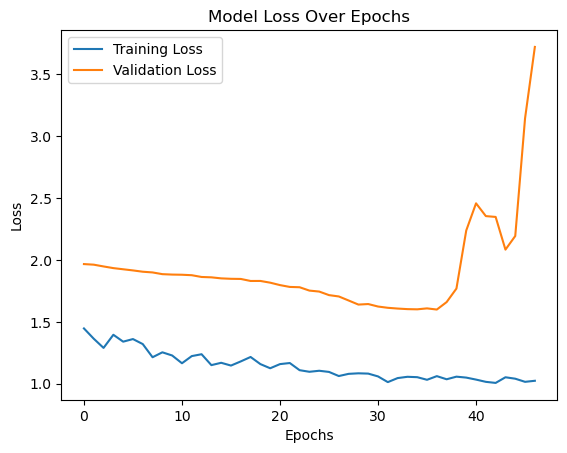

In [218]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [75]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.4788004159927368
Final Validation Loss: 2.1244993209838867
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.6659085750579834
Final Validation Loss: 2.425555467605591
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.2583562135696411
Final Validation Loss: 1.8061407804489136
Running combination 4

In [233]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 128,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-06,
    'learning_rate': 0.001,
    'l2_lambda': 0.001,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 2.5959 - val_loss: 2.0149
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.1430 - val_loss: 2.0175
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0701 - val_loss: 2.0697
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8676 - val_loss: 2.0546
Epoch 5/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.8962 - val_loss: 2.0407
Epoch 6/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.6040 - val_loss: 2.0122
Epoch 7/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6854 - val_loss: 2.0279
Epoch 8/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5075 - val_loss: 2.0261
Epoch 9/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3893 - val_loss: 2.0424
Epoch 10/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4575 - val_loss: 2.0532
Epoch 11/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1936 - val_loss: 2.0109
Epoch 12/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.014940606176332753
Test RMSE: 0.018617737449466272
Training MAE: 0.010847162805158697
Test MAE: 0.014487813080535183
Directional Accuracy on Training Data: 62.30859835100118%
Directional Accuracy on Test Data: 65.625%


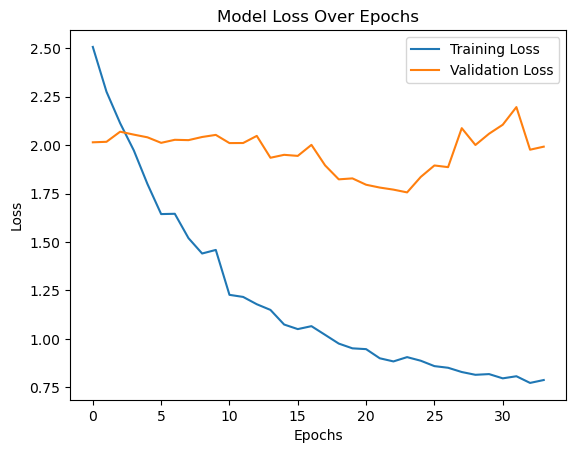

In [234]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [79]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 0.9748625159263611
Final Validation Loss: 1.8755950927734375
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.06012487411499
Final Validation Loss: 4.579287528991699
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.83113694190979
Final Validatio

In [261]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0001,
    'l2_lambda': 0.1,
    'epochs': 125,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 13.0441 - val_loss: 12.2082
Epoch 2/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 12.3689 - val_loss: 12.0398
Epoch 3/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.9957 - val_loss: 11.8632
Epoch 4/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.7346 - val_loss: 11.6834
Epoch 5/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 11.4825 - val_loss: 11.4968
Epoch 6/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.0892 - val_loss: 11.3087
Epoch 7/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.8528 - val_loss: 11.1043
Epoch 8/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.6842 - val_loss: 10.9000
Epoch 9/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.6111 - val_loss: 10.7051
Epoch 10/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.2157 - val_loss: 10.4911
Epoch 11/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.8261 - val_loss: 10.2834
Epoch 12/125
27/27 ━━━━━━━━━━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.016873515776056763
Test RMSE: 0.0179423218718199
Training MAE: 0.0119532295049653
Test MAE: 0.013875415291386695
Directional Accuracy on Training Data: 61.130742049469966%
Directional Accuracy on Test Data: 75.0%


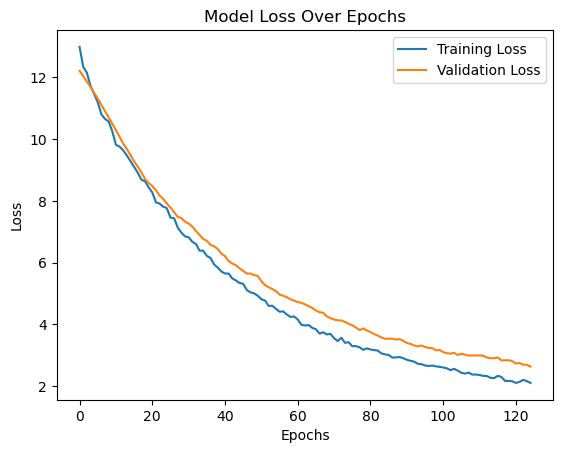

In [262]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [265]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation losses using the `scaler`
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler.scale_[0] + scaler.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler.scale_[0] + scaler.mean_[0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")

Descaled Training Loss: 0.019918604787108236
Descaled Validation Loss: 0.022214988286034895


### Model Performance Comparison (Sequence Length = 26)

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner**       | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------------|------------------------------|------------------------------|
| **Train RMSE**         | 0.013968464               | 0.015546025           | 0.014940606                  | 0.016873516                  |
| **Test RMSE**          | 0.019395004               | 0.020132029           | 0.018617737                  | 0.017942322                  |
| **Train MAE**          | 0.010971596               | 0.012908762           | 0.010847163                  | 0.011953230                  |
| **Test MAE**           | 0.014983125               | 0.015817139           | 0.014487813                  | 0.013875415                  |
| **Train Loss**         | 0.971033156               | 1.024122238           | 0.787434161                  | 2.103153467                  |
| **Validation Loss**    | 1.735087514               | 3.718303680           | 1.992423654                  | 2.631967068                  |
| **Train DA**           | 69.73%                    | 67.96%                | 62.31%                       | 61.13%                       |
| **Test DA**            | 71.88%                    | 70.31%                | 65.63%                       | 75.00%                       |                      |

- The model that achieved the best score metrics was searching the parameters using random search (3 layers). Yielding lower RMSE and MAE. In addition, in the train and val loss shows both decreases steadly over time.
- Optuna and Keras Tuner overfits (train and val loss plot).
- 
### Cross Validation with the best model with descaled metrics. 

#### **Training and Validation Loss**
| **Metric**           | **Loss**          |
|-----------------------|-------------------|
| **Training Loss**     | 0.01991860        |
| **Validation Loss**   | 0.02221498        |


#### **TSCV RMSE Values**
| **Fold** | **RMSE**         |
|----------|------------------|
| 1        | 0.01989753       |
| 2        | 0.01307778       |
| 3        | 0.01105936       |
| 4        | 0.01583083       |

**Average TSCV RMSE**: **0.01496637**

- Performance across folds are similar to previous sequence length. 

#### **FRWCV RMSE Values**
| **Window** | **RMSE**         |
|------------|------------------|
| 1          | 0.01593638       |
| 2          | 0.01128169       |
| 3          | 0.01214475       |
| 4          | 0.00797072       |
| 5          | 0.01349345       |

**Average FRWCV RMSE**: **0.01216540**

- The behavious is similar to other SL, where the model adapts to new windows, but it performs better in later windows.

In [267]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0001,
    'l2_lambda': 0.1,
    'epochs': 125,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step
Fold 1 RMSE: 1.448645760114599
Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 2 RMSE: 0.9375213483251076
Fold 3
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 3 RMSE: 0.7862459204666383
Fold 4
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Fold 4 RMSE: 1.143856529158559
Average RMSE from TSCV: 1.079067389516226


In [268]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Rolling window RMSE: 1.1517670703188143
Rolling window starting at index 100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rolling window RMSE: 0.8029091595909974
Rolling window starting at index 200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Rolling window RMSE: 0.8675931053169202
Rolling window starting at index 300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Rolling window RMSE: 0.5547594996240759
Rolling window starting at index 400
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rolling window RMSE: 0.9686750898366806
Average Rolling Window RMSE: 0.8691407849374977


In [269]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.019897529327684238, 0.01307777582932615, 0.011059360929631815, 0.015830833673690706]
Descaled FRWCV RMSE Values: [0.015936381245880968, 0.011281692676445599, 0.012144747844574895, 0.007970718923987126, 0.013493449259825487]
Average Descaled TSCV RMSE: 0.014966374940083228
Average Descaled FRWCV RMSE: 0.012165397990142813


## Sequence Length = 52

In [273]:
# Reshape residual data into sequences for LSTM.
sequence_length = 52  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")  

Reshaped X_train_seq shape: (824, 52, 1)
Reshaped y_train_seq shape: (824, 1)
Reshaped X_test_seq shape: (103, 52, 1)
Reshaped y_test_seq shape: (103, 1)


### Random Search with Optuna

In [90]:
# Set global random state for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Optuna's TPESampler with a fixed random seed for reproducibility in parameter search.
sampler = TPESampler(seed=random_seed)

# Create an Optuna study with direction "minimize" to minimize the validation loss.
study = optuna.create_study(direction="minimize", sampler=sampler)

# Define the objective function for hyperparameter optimization.
def lstm_objective(trial):
    """
    Objective function for Optuna to optimize hyperparameters of a LSTM model.
    This version uses residuals only, without additional features.
    """

    # Define hyperparameters to tune.
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.4, step=0.1)  # Dropout rate for LSTM layers.
    recurrent_dropout = trial.suggest_categorical("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout rate.
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-3, 1e-1)  # L2 regularization factor.
    learning_rate = trial.suggest_categorical("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate for the optimizer.
    learning_rate_decay = trial.suggest_categorical("learning_rate_decay", [1e-6, 1e-5, 0])  # Learning rate decay.
    clipnorm = trial.suggest_categorical("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = trial.suggest_categorical("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of LSTM layers.
    epochs = trial.suggest_int("epochs", 50, 200, step=50)  # Number of epochs.
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 120, 256])  # Batch size.

    # Initialize the Sequential model.
    model = Sequential()

    # Add LSTM layers based on num_layers.
    for i in range(num_layers):
        # Set return_sequences=True for all but the last LSTM layer.
        return_sequences = (i < num_layers - 1)
        
        # Add LSTM layer with specified hyperparameters.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,  # Input shape only for the first layer.
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))

        # Add BatchNormalization and Dropout after each LSTM layer.
        model.add(BatchNormalization())
        model.add(Dropout(dropout_rate))

    # Add the output layer with a single unit (regression).
    model.add(Dense(1))

    # Initialize the optimizer with learning rate, decay, and gradient clipping norm.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model with mean squared error loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback to avoid overfitting.
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    # Train the model with given hyperparameters.
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to suppress training logs for faster experimentation.
    )

    # Retrieve the minimum validation loss from the training history.
    val_loss = min(history.history['val_loss'])
    
    # Return the validation loss to be minimized by Optuna.
    return val_loss

# Run the Optuna study for a given number of trials.
study.optimize(lstm_objective, n_trials=30)

# Print the best parameters found by the study.
print("Best hyperparameters:", study.best_params)

# Print the best validation loss achieved with the optimal parameters.
print("Best validation loss:", study.best_value)

[I 2024-12-02 22:39:46,032] A new study created in memory with name: no-name-c5c23c43-591c-4291-8c42-d725d1cb029a
[I 2024-12-02 22:40:30,535] Trial 0 finished with value: 2.7384815216064453 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.0037550037026405905, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 3, 'epochs': 100, 'batch_size': 64}. Best is trial 0 with value: 2.7384815216064453.
[I 2024-12-02 22:41:15,802] Trial 1 finished with value: 4.809198379516602 and parameters: {'dropout_rate': 0.30000000000000004, 'recurrent_dropout': 0.2, 'l2_lambda': 0.04641587067816149, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 2, 'epochs': 50, 'batch_size': 256}. Best is trial 0 with value: 2.7384815216064453.
[I 2024-12-02 22:45:23,487] Trial 2 finished with value: 5.445192337036133 and parameters: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2

Best hyperparameters: {'dropout_rate': 0.2, 'recurrent_dropout': 0.1, 'l2_lambda': 0.015898965453252145, 'learning_rate': 0.0005, 'learning_rate_decay': 1e-05, 'clipnorm': 5.0, 'units': 64, 'num_layers': 1, 'epochs': 100, 'batch_size': 32}
Best validation loss: 2.013302803039551


In [275]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0005,
    'l2_lambda': 0.015898965453252145,
    'epochs': 100,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.1135 - val_loss: 2.2931
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1235 - val_loss: 2.2949
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1242 - val_loss: 2.2901
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0486 - val_loss: 2.2826
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1031 - val_loss: 2.2773
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0169 - val_loss: 2.2633
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0848 - val_loss: 2.2599
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0958 - val_loss: 2.2445
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0563 - val_loss: 2.2398
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0467 - val_loss: 2.2397
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0133 - val_loss: 2.2282
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.014865743972269448
Test RMSE: 0.020605752429650907
Training MAE: 0.011888785504047351
Test MAE: 0.016231053159789607
Directional Accuracy on Training Data: 71.8104495747266%
Directional Accuracy on Test Data: 71.56862745098039%


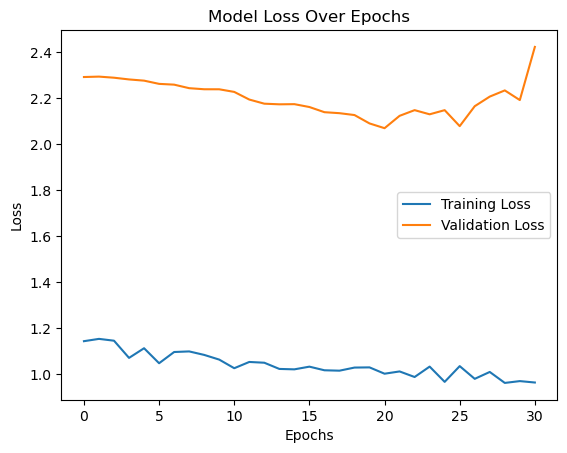

In [276]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Keras Tuner

In [94]:
# Set a global random seed for reproducibility.
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# Build LSTM model function with hyperparameter choices.
def build_lstm_model_tuner(hp):
    """
    Build an LSTM model for KerasTuner to optimize. Uses only residual sequences for input.
    """

    model = Sequential()

    # Define hyperparameters using `hp` for tuning options.
    dropout_rate = hp.Choice("dropout_rate", [0.2, 0.3, 0.4])  # Dropout rates.
    recurrent_dropout = hp.Choice("recurrent_dropout", [0.1, 0.2])  # Recurrent dropout.
    l2_lambda = hp.Float("l2_lambda", min_value=0.001, max_value=0.1, sampling="log")  # L2 regularization.
    learning_rate = hp.Choice("learning_rate", [0.001, 0.0005, 0.0001])  # Learning rate.
    learning_rate_decay = hp.Choice("learning_rate_decay", [1e-5, 0.0])  # Learning rate decay.
    clipnorm = hp.Choice("clipnorm", [1.0, 5.0])  # Gradient clipping norm.
    units = hp.Choice("units", [32, 64, 128])  # Number of units in LSTM layers.
    num_layers = hp.Int("num_layers", 1, 3)  # Number of LSTM layers.
    batch_size = hp.Choice("batch_size", [32, 64, 120, 256])  # Batch size.

    # Add LSTM layers based on the number of layers selected.
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)  # Return sequences for intermediate layers only.
        model.add(LSTM(
            units=units,
            return_sequences=return_sequences,
            input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]) if i == 0 else None,
            kernel_regularizer=l2(l2_lambda),
            recurrent_dropout=recurrent_dropout
        ))
        model.add(BatchNormalization())  # Batch normalization to stabilize training.
        model.add(Dropout(dropout_rate))  # Dropout to combat overfitting.

    # Add the output layer (regression).
    model.add(Dense(1))

    # Configure optimizer with learning rate, decay, and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)

    # Compile the model.
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Print hyperparameters for debugging.
    print(f"Built model with params: dropout_rate={dropout_rate}, recurrent_dropout={recurrent_dropout}, "
          f"l2_lambda={l2_lambda}, learning_rate={learning_rate}, learning_rate_decay={learning_rate_decay}, "
          f"clipnorm={clipnorm}, units={units}, num_layers={num_layers}, batch_size={batch_size}")

    return model


# Set up Bayesian Optimization tuner to search for optimal hyperparameters.
tuner = BayesianOptimization(
    build_lstm_model_tuner,  # Model-building function.
    objective="val_loss",  # Target metric for optimization.
    max_trials=30,  # Maximum number of trials to run.
    executions_per_trial=1,  # Number of executions per trial.
    directory="sarimax-lstm",  # Directory to store tuning results.
    project_name="sarimax-lstm",  # Project name for the tuner.
    overwrite=True  # Overwrite previous tuner results if they exist.
)

# Define early stopping to prevent overfitting.
early_stopping = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# Perform the hyperparameter search using the residuals (no features).
tuner.search(
    X_train_seq, y_train_seq,  # Training sequences and targets.
    validation_data=(X_test_seq, y_test_seq),  # Validation sequences and targets.
    epochs=200,  # Max number of epochs for each trial.
    callbacks=[early_stopping],  # Early stopping to avoid overfitting.
    shuffle=False,  # Ensure the time series order is preserved.
    verbose=1  # Show progress for each trial.
)

# Retrieve the best model and hyperparameters from the tuner.
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters found by KerasTuner.
print("Best hyperparameters for LSTM:", best_lstm_hyperparameters.values)
print("Best batch size for LSTM:", best_lstm_hyperparameters.get("batch_size"))

Trial 30 Complete [00h 03m 10s]
val_loss: 1.943796157836914

Best val_loss So Far: 1.9369709491729736
Total elapsed time: 00h 56m 43s
Built model with params: dropout_rate=0.4, recurrent_dropout=0.2, l2_lambda=0.004687701723470747, learning_rate=0.0001, learning_rate_decay=1e-05, clipnorm=1.0, units=32, num_layers=1, batch_size=64
Best hyperparameters for LSTM: {'dropout_rate': 0.4, 'recurrent_dropout': 0.2, 'l2_lambda': 0.004687701723470747, 'learning_rate': 0.0001, 'learning_rate_decay': 1e-05, 'clipnorm': 1.0, 'units': 32, 'num_layers': 1, 'batch_size': 64}
Best batch size for LSTM: 64


In [279]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0001,
    'l2_lambda': 0.004687701723470747,
    'epochs': 200,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=False, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 2.1107 - val_loss: 2.3331
Epoch 2/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9245 - val_loss: 2.3213
Epoch 3/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7784 - val_loss: 2.3122
Epoch 4/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5315 - val_loss: 2.3028
Epoch 5/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5004 - val_loss: 2.2880
Epoch 6/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4729 - val_loss: 2.2765
Epoch 7/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4312 - val_loss: 2.2659
Epoch 8/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3792 - val_loss: 2.2565
Epoch 9/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3863 - val_loss: 2.2480
Epoch 10/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2236 - val_loss: 2.2365
Epoch 11/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3278 - val_loss: 2.2213
Epoch 12/200
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
LSTM Model Performance:
Training RMSE: 0.013638888114675386
Test RMSE: 0.020862546885234833
Training MAE: 0.010061235760442386
Test MAE: 0.016549538671778056
Directional Accuracy on Training Data: 72.78250303766707%
Directional Accuracy on Test Data: 66.66666666666666%


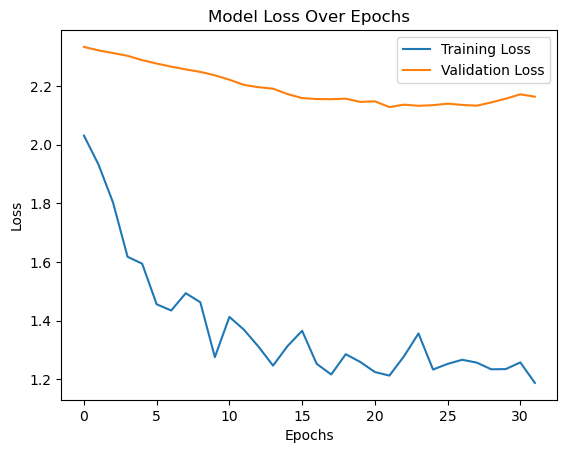

In [280]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 2 Layers

In [98]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid for random hyperparameter search.
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],               # Dropout rate for regularization.
    'recurrent_dropout': [0.1, 0.2],               # Recurrent dropout within LSTM layers.
    'l2_lambda': [0.001, 0.01, 0.1],               # L2 regularization strength.
    'learning_rate': [0.001, 0.0005, 0.0001],      # Learning rate for optimizer.
    'learning_rate_decay': [1e-6, 1e-5, 0],        # Decay rate for learning rate over time.
    'units1': [32, 64, 128],                       # Number of units in the first LSTM layer.
    'units2': [32, 64, 128],                       # Number of units in the second LSTM layer.
    'batch_size': [32, 64, 120, 256],              # Batch size for training.
    'epochs': [50, 100, 200],                      # Number of epochs to train.
    'optimizer': ['adam'],                         # Optimizer to use.
    'clipnorm': [1.0, 5.0]                         # Gradient clipping to avoid exploding gradients.
}

# Generate a list of random combinations of hyperparameters.
n_iter_search = 30  # Number of random combinations to attempt.
# Random state being applied for reproducibility. 
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42)) 

# Define a function to build the LSTM model with given parameters.
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, optimizer_name, loss_function):
    model = Sequential()
    
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape based on sequence data.
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())  # Batch normalization for stable training.
    model.add(Dropout(dropout_rate))  # Dropout for regularization.
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout.
    model.add(LSTM(units=units2, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer with a single unit for regression output.
    model.add(Dense(1))
    
    # Select optimizer with learning rate decay and gradient clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile the model with the chosen optimizer and loss function.
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Define early stopping to stop training when validation loss does not improve.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to store results of each model configuration.
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        callbacks=[early_stopping],
        shuffle=False,
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.01, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 5.0, 'batch_size': 64}
Final Training Loss: 1.3379141092300415
Final Validation Loss: 2.482337474822998
Running combination 2/30: {'units2': 128, 'units1': 64, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.001, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 1.882140040397644
Final Validation Loss: 2.8708503246307373
Running combination 3/30: {'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 0, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.3, 'clipnorm': 1.0, 'batch_size': 64}
Final Training Loss: 1.7402417659759521
Final Validation Loss: 2.5461206436157227
Running combination 4/

In [303]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 64,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.4,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 5.1263 - val_loss: 2.3307
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.0976 - val_loss: 2.3327
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.7146 - val_loss: 2.3266
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.1345 - val_loss: 2.3219
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.7601 - val_loss: 2.3110
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.6011 - val_loss: 2.3125
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.6177 - val_loss: 2.2991
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6184 - val_loss: 2.3045
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.5427 - val_loss: 2.2881
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.1919 - val_loss: 2.2833
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.2982 - val_loss: 2.2574
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
LSTM Model Performance:
Training RMSE: 0.014167530549217098
Test RMSE: 0.02063629096774174
Training MAE: 0.010957686207444617
Test MAE: 0.016197359122783205
Directional Accuracy on Training Data: 71.8104495747266%
Directional Accuracy on Test Data: 73.52941176470588%


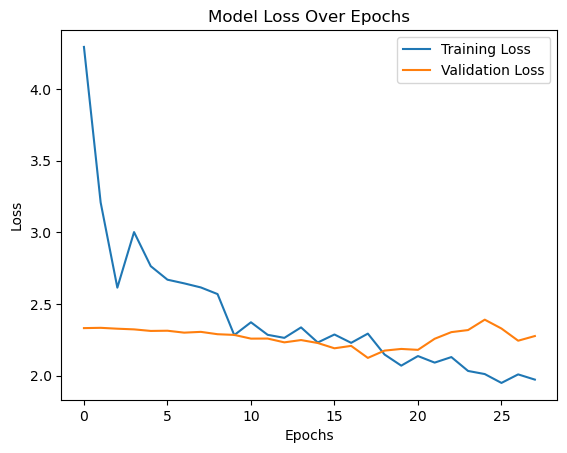

In [304]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Random Search with 3 Layers

In [102]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Define parameter grid
param_grid = {
    'dropout_rate': [0.2, 0.3, 0.4],
    'recurrent_dropout': [0.1, 0.2],
    'l2_lambda': [0.001, 0.01, 0.1],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'learning_rate_decay': [1e-6, 1e-5, 0],
    'units1': [32, 64, 128],
    'units2': [32, 64, 128],
    'units3': [32, 64, 128],
    'batch_size': [32, 64, 120, 256],  
    'epochs': [50, 100, 200],
    'optimizer': ['adam'],
    'clipnorm': [1.0, 5.0]
}

# Generate a list of random combinations with ParameterSampler
n_iter_search = 30
random_combinations = list(ParameterSampler(param_grid, n_iter=n_iter_search, random_state=42))

# Define the function to build the model with variable parameters
def build_model(dropout_rate, recurrent_dropout, l2_lambda, learning_rate, learning_rate_decay, clipnorm, units1, units2, units3, optimizer_name, loss_function):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units1, return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
                   kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units2, return_sequences=True, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=units3, return_sequences=False, kernel_regularizer=l2(l2_lambda), recurrent_dropout=recurrent_dropout))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))
    
    # Output layer.
    model.add(Dense(1))
    
    # Select optimizer with decay and clipping.
    optimizer = Adam(learning_rate=learning_rate, decay=learning_rate_decay, clipnorm=clipnorm)
    
    # Compile model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Placeholder to keep track of results
results = []

# Run random search
for i, params in enumerate(random_combinations):
    print(f"Running combination {i+1}/{len(random_combinations)}: {params}")
    
    # Build model with the current parameters
    model = build_model(
        dropout_rate=params['dropout_rate'],
        recurrent_dropout=params['recurrent_dropout'],
        l2_lambda=params['l2_lambda'],
        learning_rate=params['learning_rate'],
        learning_rate_decay=params['learning_rate_decay'],
        clipnorm=params['clipnorm'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3'],
        optimizer_name=params['optimizer'],
        loss_function='mean_squared_error'
    )
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=params['epochs'], 
        batch_size=params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        callbacks=[early_stopping],
        verbose=0  # Set verbose=0 to reduce output
    )
    
    # Get final validation loss and training loss
    final_val_loss = history.history['val_loss'][-1]
    final_train_loss = history.history['loss'][-1]
    
    # Store the results
    results.append({
        'params': params,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    })
    
    print(f"Final Training Loss: {final_train_loss}")
    print(f"Final Validation Loss: {final_val_loss}")

results = sorted(results, key=lambda x: x['final_val_loss'])
print("Top results:")
for res in results[:5]:  # Show top 5 results
    print(res)

Running combination 1/30: {'units3': 32, 'units2': 32, 'units1': 32, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-05, 'learning_rate': 0.0005, 'l2_lambda': 0.1, 'epochs': 100, 'dropout_rate': 0.2, 'clipnorm': 5.0, 'batch_size': 32}
Final Training Loss: 1.017672061920166
Final Validation Loss: 3.7521581649780273
Running combination 2/30: {'units3': 128, 'units2': 64, 'units1': 128, 'recurrent_dropout': 0.2, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0001, 'l2_lambda': 0.01, 'epochs': 50, 'dropout_rate': 0.2, 'clipnorm': 1.0, 'batch_size': 32}
Final Training Loss: 4.174684524536133
Final Validation Loss: 4.96322774887085
Running combination 3/30: {'units3': 128, 'units2': 64, 'units1': 64, 'recurrent_dropout': 0.1, 'optimizer': 'adam', 'learning_rate_decay': 1e-06, 'learning_rate': 0.0005, 'l2_lambda': 0.001, 'epochs': 200, 'dropout_rate': 0.4, 'clipnorm': 5.0, 'batch_size': 256}
Final Training Loss: 2.9794578552246094
Final Validati

In [327]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 3.6706 - val_loss: 2.3988
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 2.5888 - val_loss: 2.3964
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.6410 - val_loss: 2.3927
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.5164 - val_loss: 2.3884
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.1724 - val_loss: 2.3825
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.3528 - val_loss: 2.3721
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.1951 - val_loss: 2.3554
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0442 - val_loss: 2.3326
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 2.1779 - val_loss: 2.3223
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 1.9099 - val_loss: 2.2895
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.1725 - val_loss: 2.2588
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
LSTM Model Performance:
Training RMSE: 0.014220688931729827
Test RMSE: 0.019657384294812973
Training MAE: 0.01048819717244213
Test MAE: 0.015636268568564603
Directional Accuracy on Training Data: 65.12758201701094%
Directional Accuracy on Test Data: 74.50980392156863%


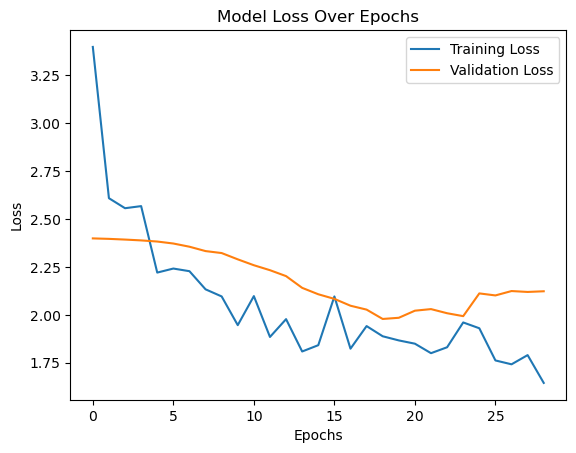

In [328]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [332]:
# Extract scaled train and validation loss from history
scaled_train_loss = history.history['loss'][-1]  # Final train loss
scaled_val_loss = history.history['val_loss'][-1]  # Final validation loss

# Descale train and validation losses using the `scaler`
descaled_train_loss = np.sqrt(scaled_train_loss) * scaler.scale_[0] + scaler.mean_[0]
descaled_val_loss = np.sqrt(scaled_val_loss) * scaler.scale_[0] + scaler.mean_[0]

# Print the descaled losses
print(f"Descaled Training Loss: {descaled_train_loss}")
print(f"Descaled Validation Loss: {descaled_val_loss}")


Descaled Training Loss: 0.0176782069274584
Descaled Validation Loss: 0.020008864866354895


### Model Performance Comparison (Sequence Length = 52)

| **Metric**            | **Random Search (Optuna)** | **Keras Tuner**       | **Random Search (2 Layers)** | **Random Search (3 Layers)** |
|------------------------|---------------------------|-----------------------|-----------------------------|-----------------------------|
| **Train RMSE**         | 0.014865743              | 0.013638888           | 0.014167531                  | 0.014220689                  |
| **Test RMSE**          | 0.020605752              | 0.020862547           | 0.020636291                  | 0.019657384                  |
| **Train MAE**          | 0.011888786              | 0.010061236           | 0.010957686                  | 0.010488197                  |
| **Test MAE**           | 0.016231053              | 0.016549539           | 0.016197359                  | 0.015636269                  |
| **Train Loss**         | 0.962035298              | 1.188136339           | 1.971406698                  | 1.644326091                  |
| **Validation Loss**    | 2.424255133              | 2.163613319           | 2.275382280                  | 2.122820139                  |
| **Train DA**           | 71.81%                   | 72.78%                | 71.81%                       | 65.13%                      |
| **Test DA**            | 71.57%                   | 66.67%                | 73.53%                       | 74.51%                      |

- The random search with 3 layers presented the lowest metrics for the test sets. And by observing the train and val loss plot the model is the one that have less chance to overfit. 

### Cross Validation of the best model (Keras Tuner) with descaled metrics 

#### Training and Validation Loss
| **Metric**           | **Loss**        |
|-----------------------|-----------------|
| **Training Loss**     | 0.01767821      |
| **Validation Loss**   | 0.02000886      |

#### TSCV RMSE Values
| **Fold** | **RMSE**         |
|----------|------------------|
| **1**    | 0.02036113       |
| **2**    | 0.01078781       |
| **3**    | 0.01099438       |
| **4**    | 0.01655056       |

**Average TSCV RMSE**: **0.01467347**

- The TSCV shows that the behaviour of the model is similar to the SL 4, 12 and 26. However, it shows higher RMSE scores and indicating that the model make "higher" errors when sequence length is increased.  

#### FRWCV RMSE Values
| **Window** | **RMSE**         |
|------------|------------------|
| **1**      | 0.01681134       |
| **2**      | 0.01018159       |
| **3**      | 0.01244451       |
| **4**      | 0.00751678       |
| **5**      | 0.01442107       |

**Average FRWCV RMSE**: **0.01227506**

- The model shows stability on the predictions on the 2,3 and 4 window, but it struggles at the first and last window. 

In [334]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 64,
    'recurrent_dropout': 0.1,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 0,
    'learning_rate': 0.0001,
    'l2_lambda': 0.001,
    'epochs': 100,
    'dropout_rate': 0.3,
    'clipnorm': 1.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer
    model.add(Dense(1))
    
    # Select the optimizer
    optimizer = Adam(learning_rate=params['learning_rate'], 
                     decay=params['learning_rate_decay'], 
                     clipnorm=params['clipnorm'])
    
    # Compile the model
    model.compile(optimizer=optimizer, loss=params['loss_function'])
    
    return model

# Define the number of splits for Time Series Cross-Validation
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize the list to store RMSE scores
tscv_rmse_scores = []

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Create the model once and save its initial weights
model = build_best_model(best_params)
initial_weights = model.get_weights()

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(y_train_scaled)):
    print(f"Fold {fold + 1}")

    # Reset model to initial weights
    model.set_weights(initial_weights)
    
    # Define train and test sets
    y_train_fold, y_test_fold = y_train_scaled[train_index], y_train_scaled[test_index]
    
    # Create sequences for TSCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        validation_data=(X_test_seq, y_test_seq),
        shuffle=False,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    # Predict and evaluate
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate the average RMSE across all folds
avg_rmse = np.mean(tscv_rmse_scores)
print(f"Average RMSE from TSCV: {avg_rmse}")

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step
Fold 1 RMSE: 1.483391667183457
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Fold 2 RMSE: 0.7658938166205912
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Fold 3 RMSE: 0.7813757084095933
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Fold 4 RMSE: 1.1977982063439072
Average RMSE from TSCV: 1.0571148496393872


In [335]:
# Parameters for FRWCV
train_window = 300  # Training window size
test_window = 100    # Test window size

# Store RMSEs for each window
rolling_rmse_scores = []

for start in range(0, len(y_train_scaled) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define train and test sets for the window
    y_train_fold = y_train_scaled[start:start + train_window]
    y_test_fold = y_train_scaled[start + train_window:start + train_window + test_window]
    
    # Create sequences for FRWCV
    X_train_seq, y_train_seq = [], []
    for i in range(len(y_train_fold) - sequence_length):
        X_train_seq.append(y_train_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_train_seq.append(y_train_fold[i + sequence_length])    # Next residual value as target.
    
    X_test_seq, y_test_seq = [], []
    for i in range(len(y_test_fold) - sequence_length):
        X_test_seq.append(y_test_fold[i:i + sequence_length])  # Sequence of past residuals.
        y_test_seq.append(y_test_fold[i + sequence_length])    # Next residual value as target.
    
    # Convert to numpy arrays
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)
    
    # Train the model
    model.set_weights(initial_weights)  # Reset to initial weights
    history = model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        shuffle=False,
        verbose=0,  # Suppress training logs for brevity
        callbacks=[early_stopping]
    )
    
    # Evaluate on the test set
    y_pred = model.predict(X_test_seq)
    rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across rolling windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Rolling window RMSE: 1.2173434316445715
Rolling window starting at index 100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Rolling window RMSE: 0.7204588027280416
Rolling window starting at index 200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Rolling window RMSE: 0.8900594900048304
Rolling window starting at index 300
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Rolling window RMSE: 0.520737912411776
Rolling window starting at index 400
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Rolling window RMSE: 1.038197835189639
Average Rolling Window RMSE: 0.8773594943957719


In [336]:
# Function to descale RMSE
def descale_rmse(scaled_rmse, scaler):
    # Reshape RMSE value to fit scaler requirements
    scaled_rmse_array = np.array(scaled_rmse).reshape(-1, 1)
    # Inverse transform the RMSE
    descaled_rmse_array = scaler.inverse_transform(scaled_rmse_array)
    # Return the descaled RMSE as a list
    return descaled_rmse_array.flatten().tolist()

# Descale TSCV RMSE values
descaled_tscv_rmse = descale_rmse(tscv_rmse_scores, scaler)
print("Descaled TSCV RMSE Values:", descaled_tscv_rmse)

# Descale FRWCV RMSE values
descaled_frwcv_rmse = descale_rmse(rolling_rmse_scores, scaler)
print("Descaled FRWCV RMSE Values:", descaled_frwcv_rmse)

# Calculates average descaled RMSE
average_tscv_rmse = np.mean(descaled_tscv_rmse)
average_frwcv_rmse = np.mean(descaled_frwcv_rmse)
print(f"Average Descaled TSCV RMSE: {average_tscv_rmse}")
print(f"Average Descaled FRWCV RMSE: {average_frwcv_rmse}")

Descaled TSCV RMSE Values: [0.0203611317614965, 0.010787809956519245, 0.010994379400775672, 0.016550558525814555]
Descaled FRWCV RMSE Values: [0.016811343601905383, 0.0101815865248173, 0.012444508924337088, 0.007516780835609663, 0.014421066831790662]
Average Descaled TSCV RMSE: 0.014673469911151493
Average Descaled FRWCV RMSE: 0.01227505734369202


## Evaluation of optimal model for Standard Scaler 

The next table will be composed by the best model for each sequence length. The technologies will be evaluated to decide which sequence length is the optimal for the model and scaler.

### Best Model Performance Across Sequence Lengths (SL)

| **Sequence Length (SL)** | **Train RMSE** | **Test RMSE** | **Train MAE** | **Test MAE** | **Train DA** | **Test DA** | **Train Loss** | **Validation Loss** |
|---------------------------|----------------|---------------|---------------|--------------|--------------|-------------|----------------|---------------------|
| **4**                    | 0.013356582    | 0.018489964   | 0.009746902   | 0.014106353  | 65.10%       | 69.33%      | 1.003827810    | 2.019451618         |
| **12**                   | 0.013553748    | 0.018046680   | 0.009725744   | 0.013830640  | 69.99%       | 71.83%      | 0.982941508    | 1.867849946         |
| **26**                   | 0.016873516    | 0.017942322   | 0.011953230   | 0.013875415  | 61.13%       | 75.00%      | 2.103153467    | 2.631967068         |
| **52**                   | 0.014220689    | 0.019657384   | 0.010488197   | 0.015636269  | 65.13%       | 74.51%      | 1.644326091    | 2.122820139         |


### TSCV RMSE Comparison

| **Sequence Length (SL)** | **Fold 1 RMSE** | **Fold 2 RMSE** | **Fold 3 RMSE** | **Fold 4 RMSE** | **Average TSCV RMSE** | **Training Loss** | **Validation Loss** |
|---------------------------|-----------------|-----------------|-----------------|-----------------|------------------------|-------------------|---------------------|
| **SL = 4**               | 0.01891854      | 0.01304871      | 0.01124474      | 0.01666118      | **0.01496829**         | 0.01393692        | 0.01952965          |
| **SL = 12**              | 0.01891142      | 0.01297662      | 0.01149948      | 0.01556677      | **0.01473857**         | 0.01379711        | 0.01880406          |
| **SL = 26**              | 0.01989753      | 0.01307778      | 0.01105936      | 0.01583083      | **0.01446638**         | 0.01991860        | 0.02221498          |
| **SL = 52**              | 0.02036113      | 0.01078781      | 0.01099438      | 0.01655056      | **0.01467347**         | 0.01767821        | 0.02000886          |

---

### FRWCV RMSE Comparison

| **Sequence Length (SL)** | **Window 1 RMSE** | **Window 2 RMSE** | **Window 3 RMSE** | **Window 4 RMSE** | **Window 5 RMSE** | **Average FRWCV RMSE** |
|---------------------------|-------------------|-------------------|-------------------|-------------------|-------------------|------------------------|
| **SL = 4**               | 0.01610436        | 0.01132182        | 0.01130602        | 0.01038270        | 0.01240948        | **0.01230488**         |
| **SL = 12**              | 0.01681824        | 0.01127772        | 0.01217473        | 0.01004578        | 0.01323356        | **0.01271000**         |
| **SL = 26**              | 0.01593638        | 0.01128169        | 0.01214475        | 0.00797072        | 0.01349345        | **0.01216540**         |
| **SL = 52**              | 0.01681134        | 0.01018159        | 0.01244451        | 0.00751678        | 0.01442107        | **0.01227506**         |

---

**The final model of the present workflow has the sequence length of 26**. The architecture:
- Achieved the lowest RMSE metrics and the second MAE.
- Close Train and Val Loss plot shows that the SL = 26 has the best convergence where the train and val decreases steadly and the gaps between them are not wide.
- The model scored the lowest average in the TSCV and the FRWCV, showing robustness on both cross-validation approaches. 

In [25]:
# Reshape residual data into sequences for LSTM.
sequence_length = 26  # Number of time steps used for target prediction.

# Initialize empty lists for the training set.
X_train_seq, y_train_seq = [], []
# Loop through the scaled training residuals to create sequences and targets.
for i in range(len(y_train_scaled) - sequence_length):
    X_train_seq.append(y_train_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_train_seq.append(y_train_scaled[i + sequence_length])    # Next residual value as target.

# Initialize empty lists for the test set.
X_test_seq, y_test_seq = [], []
# Loop through the scaled test residuals to create sequences and targets.
for i in range(len(y_test_scaled) - sequence_length):
    X_test_seq.append(y_test_scaled[i:i + sequence_length])  # Sequence of past residuals.
    y_test_seq.append(y_test_scaled[i + sequence_length])    # Next residual value as target.

# Convert lists to numpy arrays to use in LSTM model.
X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)
X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

# Print the reshaped input and target data shapes for verification.
print(f"Reshaped X_train_seq shape: {X_train_seq.shape}") 
print(f"Reshaped y_train_seq shape: {y_train_seq.shape}") 
print(f"Reshaped X_test_seq shape: {X_test_seq.shape}")    
print(f"Reshaped y_test_seq shape: {y_test_seq.shape}")    

Reshaped X_train_seq shape: (850, 26, 1)
Reshaped y_train_seq shape: (850, 1)
Reshaped X_test_seq shape: (129, 26, 1)
Reshaped y_test_seq shape: (129, 1)


In [26]:
# Set random seeds for reproducibility
random_seed = 40
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)

# Best hyperparameters found from tuning
best_params = {
    'units1': 32,
    'units2': 32,
    'units3': 32,
    'recurrent_dropout': 0.2,
    'optimizer': 'adam',
    'loss_function': 'mean_squared_error',
    'learning_rate_decay': 1e-05,
    'learning_rate': 0.0001,
    'l2_lambda': 0.1,
    'epochs': 125,
    'dropout_rate': 0.2,
    'clipnorm': 5.0,
    'batch_size': 32
}

# Build the model using the best parameters
def build_best_model(params):
    model = Sequential()
    # First LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units1'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))

        # Second LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units2'], return_sequences=True, 
                   input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),  # Input shape for residual sequences
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Third LSTM layer with BatchNorm, Dropout, and recurrent_dropout
    model.add(LSTM(units=params['units3'], return_sequences=False, 
                   kernel_regularizer=l2(params['l2_lambda']), 
                   recurrent_dropout=params['recurrent_dropout']))
    model.add(BatchNormalization())
    model.add(Dropout(params['dropout_rate']))
    
    # Output layer for regression
    model.add(Dense(1))
    
    # Select the optimizer
    if params['optimizer'] == 'adam':
        optimizer = Adam(learning_rate=params['learning_rate'], decay=params['learning_rate_decay'], clipnorm=params['clipnorm'])
    else:
        raise ValueError(f"Optimizer '{params['optimizer']}' is not implemented in this setup.")
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

# Instantiate the model with the best hyperparameters
model = build_best_model(best_params)

# Early stopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train_seq,  # Training residual sequences and targets
    epochs=best_params['epochs'], 
    batch_size=best_params['batch_size'], 
    validation_data=(X_test_seq, y_test_seq),  # Validation residual sequences and targets
    shuffle=False,
    callbacks=[early_stopping]
)

# Print the final training and validation loss
print(f"Final Training Loss: {history.history['loss'][-1]}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]}")

Epoch 1/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 13.0441 - val_loss: 12.2082
Epoch 2/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12.3689 - val_loss: 12.0398
Epoch 3/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 11.9957 - val_loss: 11.8632
Epoch 4/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.7346 - val_loss: 11.6834
Epoch 5/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.4825 - val_loss: 11.4968
Epoch 6/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 11.0892 - val_loss: 11.3087
Epoch 7/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.8528 - val_loss: 11.1043
Epoch 8/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.6842 - val_loss: 10.9000
Epoch 9/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.6111 - val_loss: 10.7051
Epoch 10/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.2157 - val_loss: 10.4911
Epoch 11/125
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.8261 - val_loss: 10.2834
Epoch 12/125
27/27 ━━━━━━━━━━━━━━

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
LSTM Model Performance:
Training RMSE: 0.016873515776056763
Test RMSE: 0.0179423218718199
Training MAE: 0.0119532295049653
Test MAE: 0.013875415291386695
Directional Accuracy on Training Data: 61.130742049469966%
Directional Accuracy on Test Data: 75.0%


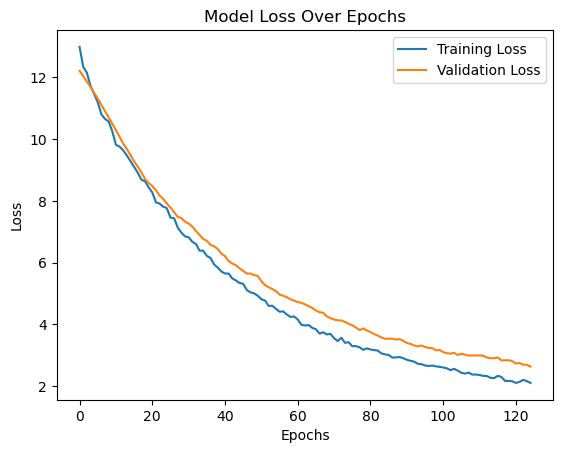

In [27]:
# Predict on both training and test sequences
y_train_pred = model.predict(X_train_seq)  # Predictions on training residual sequences
y_test_pred = model.predict(X_test_seq)   # Predictions on test residual sequences

# Inverse scale predictions and actual values back to the original scale
y_train_pred_rescaled = scaler.inverse_transform(y_train_pred)
y_test_pred_rescaled = scaler.inverse_transform(y_test_pred)
y_train_actual_rescaled = scaler.inverse_transform(y_train_seq)
y_test_actual_rescaled = scaler.inverse_transform(y_test_seq)

# Define a function for directional accuracy
def directional_accuracy(y_true, y_pred):
    """
    Calculate directional accuracy between true values and predictions.
    Measures the percentage of times the direction of change is correctly predicted.
    """
    return np.mean((np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1])).astype(int)) * 100

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
train_rmse = np.sqrt(mean_squared_error(y_train_actual_rescaled, y_train_pred_rescaled))
test_rmse = np.sqrt(mean_squared_error(y_test_actual_rescaled, y_test_pred_rescaled))
# Mean Absolute Error (MAE)
train_mae = mean_absolute_error(y_train_actual_rescaled, y_train_pred_rescaled)
test_mae = mean_absolute_error(y_test_actual_rescaled, y_test_pred_rescaled)
# Directional Accuracy
train_directional_accuracy = directional_accuracy(y_train_actual_rescaled.flatten(), y_train_pred_rescaled.flatten())
test_directional_accuracy = directional_accuracy(y_test_actual_rescaled.flatten(), y_test_pred_rescaled.flatten())

# Display performance metrics
print("LSTM Model Performance:")
print(f"Training RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Training MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Directional Accuracy on Training Data: {train_directional_accuracy}%")
print(f"Directional Accuracy on Test Data: {test_directional_accuracy}%")

# Plot training & validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [53]:
# Predict residuals for the training set
lstm_train_residuals = model.predict(X_train_seq)
lstm_train_residuals = scaler.inverse_transform(lstm_train_residuals)

# Predict residuals for the test set
lstm_test_residuals = model.predict(X_test_seq)
lstm_test_residuals = scaler.inverse_transform(lstm_test_residuals)

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [54]:
# Truncate SARIMAX predictions to align with LSTM predictions
aligned_train_predictions = train_predictions[sequence_length:]  # SL = 26
aligned_test_predictions = test_predictions[sequence_length:]

# Combine SARIMAX and LSTM predictions
hybrid_train_predictions = aligned_train_predictions + lstm_train_residuals.flatten()
hybrid_test_predictions = aligned_test_predictions + lstm_test_residuals.flatten()

# Validate shapes
print(f"Hybrid Train Predictions Length: {len(hybrid_train_predictions)}")
print(f"Hybrid Test Predictions Length: {len(hybrid_test_predictions)}")

Hybrid Train Predictions Length: 850
Hybrid Test Predictions Length: 129


In [55]:
# Align train dataset by truncating the first SL points
aligned_train = train[sequence_length:] 

# Align test dataset by truncating the first SL points
aligned_test = test[sequence_length:]  

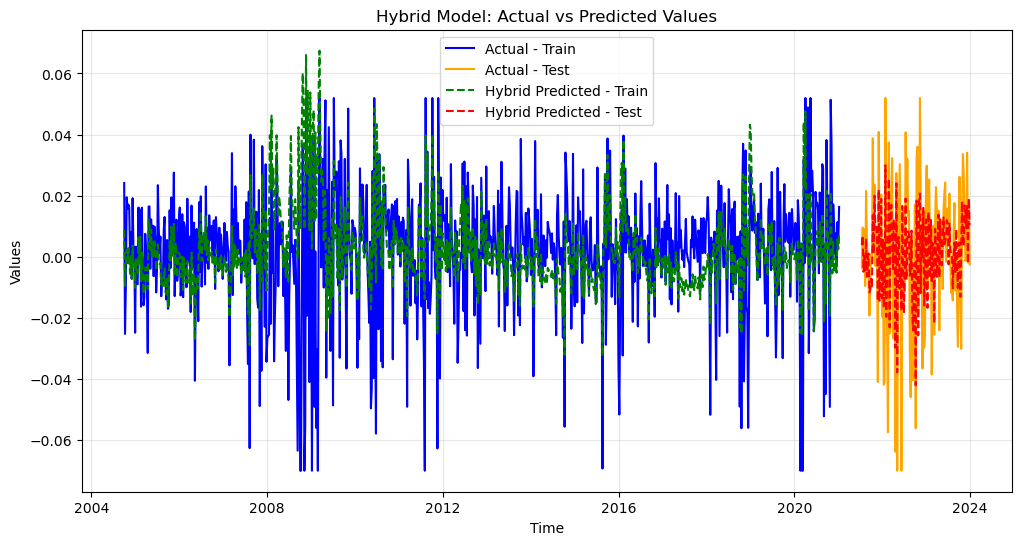

In [56]:
# Ensure hybrid test predictions are properly indexed
hybrid_test_predictions = pd.Series(hybrid_test_predictions, index=aligned_test.index)

# Plot actual vs hybrid predictions for training and test sets
plt.figure(figsize=(12, 6))
plt.plot(aligned_train.index, aligned_train, label="Actual - Train", color="blue")
plt.plot(aligned_test.index, aligned_test, label="Actual - Test", color="orange")
plt.plot(aligned_train.index, hybrid_train_predictions, label="Hybrid Predicted - Train", linestyle="--", color="green")
plt.plot(aligned_test.index, hybrid_test_predictions, label="Hybrid Predicted - Test", linestyle="--", color="red")

# Finalize plot
plt.legend()
plt.title("Hybrid Model: Actual vs Predicted Values")
plt.xlabel("Time")
plt.ylabel("Values")
plt.grid(alpha=0.3)
plt.show()

In [57]:
# Function to calculate Directional Accuracy
def directional_accuracy(actual, predicted):
    # Compare the direction of changes (increase or decrease) between actual and predicted values
    actual_direction = np.sign(np.diff(actual))
    predicted_direction = np.sign(np.diff(predicted))
    correct_directions = np.sum(actual_direction == predicted_direction)
    total_directions = len(actual_direction)
    return (correct_directions / total_directions) * 100

# Evaluate hybrid model on training data
hybrid_train_rmse = mean_squared_error(aligned_train, hybrid_train_predictions, squared=False)
hybrid_train_mae = mean_absolute_error(aligned_train, hybrid_train_predictions)
hybrid_train_da = directional_accuracy(aligned_train, hybrid_train_predictions)

# Evaluate hybrid model on testing data
hybrid_test_rmse = mean_squared_error(aligned_test, hybrid_test_predictions, squared=False)
hybrid_test_mae = mean_absolute_error(aligned_test, hybrid_test_predictions)
hybrid_test_da = directional_accuracy(aligned_test, hybrid_test_predictions)

# Print metrics
print(f"Hybrid Training RMSE: {hybrid_train_rmse}")
print(f"Hybrid Test RMSE: {hybrid_test_rmse}")
print(f"Hybrid Training MAE: {hybrid_train_mae}")
print(f"Hybrid Test MAE: {hybrid_test_mae}")
print(f"Hybrid Training Directional Accuracy: {hybrid_train_da:.2f}%")
print(f"Hybrid Test Directional Accuracy: {hybrid_test_da:.2f}%")

Hybrid Training RMSE: 0.016873515776056763
Hybrid Test RMSE: 0.0179423218718199
Hybrid Training MAE: 0.0119532295049653
Hybrid Test MAE: 0.013875415291386695
Hybrid Training Directional Accuracy: 89.52%
Hybrid Test Directional Accuracy: 75.78%


In [37]:
# Define TSCV
n_splits = 4
tscv = TimeSeriesSplit(n_splits=n_splits)
tscv_rmse_scores = []

# Perform TSCV
for fold, (train_index, test_index) in enumerate(tscv.split(train)):
    print(f"Fold {fold + 1}")
    
    # Split data into train and validation sets
    train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]
    exo_train_fold, exo_test_fold = exo_train.iloc[train_index], exo_train.iloc[test_index]

    # Step 1: Train SARIMAX on the training fold
    sarimax_model = SARIMAX(train_fold, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train_fold)
    sarimax_result = sarimax_model.fit(disp=False)

    # Predict using SARIMAX
    train_predictions = sarimax_result.predict(start=0, end=len(train_fold)-1, exog=exo_train_fold)
    test_predictions = sarimax_result.forecast(steps=len(test_fold), exog=exo_test_fold)

    # Step 2: Calculate residuals for LSTM
    residuals_train = train_fold - train_predictions
    residuals_test = test_fold - test_predictions

    # Scale residuals
    residuals_train_scaled = scaler.fit_transform(residuals_train.values.reshape(-1, 1))
    residuals_test_scaled = scaler.transform(residuals_test.values.reshape(-1, 1))

    # Create sequences for LSTM
    X_train_seq, y_train_seq = [], []
    for i in range(len(residuals_train_scaled) - sequence_length):
        X_train_seq.append(residuals_train_scaled[i:i + sequence_length])
        y_train_seq.append(residuals_train_scaled[i + sequence_length])
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

    X_test_seq, y_test_seq = [], []
    for i in range(len(residuals_test_scaled) - sequence_length):
        X_test_seq.append(residuals_test_scaled[i:i + sequence_length])
        y_test_seq.append(residuals_test_scaled[i + sequence_length])
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

    # Step 3: Train LSTM on residuals
    lstm_model = build_best_model(best_params)
    history = lstm_model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        verbose=0,
        callbacks=[early_stopping]
    )

    # Predict residuals using LSTM
    lstm_residual_predictions = lstm_model.predict(X_test_seq)
    lstm_residual_predictions = scaler.inverse_transform(lstm_residual_predictions)

    # Combine SARIMAX and LSTM predictions
    hybrid_predictions = test_predictions[sequence_length:] + lstm_residual_predictions.flatten()

    # Evaluate hybrid model
    actual_values = test_fold.iloc[sequence_length:]
    rmse = np.sqrt(mean_squared_error(actual_values, hybrid_predictions))
    tscv_rmse_scores.append(rmse)
    print(f"Fold {fold + 1} RMSE: {rmse}")

# Calculate average RMSE across folds
avg_tscv_rmse = np.mean(tscv_rmse_scores)
print(f"Average TSCV RMSE: {avg_tscv_rmse}")

Fold 1
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Fold 1 RMSE: 0.024166473279888648
Fold 2
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Fold 2 RMSE: 0.015493561696393586
Fold 3
1/5 ━━━━━━━━━━━━━━━━━━━━ 1s 315ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002C99C240AE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step
Fold 3 RMSE: 0.0128592938884092

In [38]:
# Define FRWCV parameters
train_window = 300
test_window = 50
rolling_rmse_scores = []

# Perform FRWCV
for start in range(0, len(train) - train_window - test_window, test_window):
    print(f"Rolling window starting at index {start}")
    
    # Define training and test sets
    train_fold = train[start:start + train_window]
    test_fold = train[start + train_window:start + train_window + test_window]
    exo_train_fold = exo_train[start:start + train_window]
    exo_test_fold = exo_train[start + train_window:start + train_window + test_window]

    # Step 1: Train SARIMAX on the training window
    sarimax_model = SARIMAX(train_fold, order=(1, 0, 3), seasonal_order=(1, 0, 2, 52), exog=exo_train_fold)
    sarimax_result = sarimax_model.fit(disp=False)

    # Predict using SARIMAX
    train_predictions = sarimax_result.predict(start=0, end=len(train_fold)-1, exog=exo_train_fold)
    test_predictions = sarimax_result.forecast(steps=len(test_fold), exog=exo_test_fold)

    # Step 2: Calculate residuals for LSTM
    residuals_train = train_fold - train_predictions
    residuals_test = test_fold - test_predictions

    # Scale residuals
    residuals_train_scaled = scaler.fit_transform(residuals_train.values.reshape(-1, 1))
    residuals_test_scaled = scaler.transform(residuals_test.values.reshape(-1, 1))

    # Create sequences for LSTM
    X_train_seq, y_train_seq = [], []
    for i in range(len(residuals_train_scaled) - sequence_length):
        X_train_seq.append(residuals_train_scaled[i:i + sequence_length])
        y_train_seq.append(residuals_train_scaled[i + sequence_length])
    X_train_seq, y_train_seq = np.array(X_train_seq), np.array(y_train_seq)

    X_test_seq, y_test_seq = [], []
    for i in range(len(residuals_test_scaled) - sequence_length):
        X_test_seq.append(residuals_test_scaled[i:i + sequence_length])
        y_test_seq.append(residuals_test_scaled[i + sequence_length])
    X_test_seq, y_test_seq = np.array(X_test_seq), np.array(y_test_seq)

    # Step 3: Train LSTM on residuals
    lstm_model = build_best_model(best_params)
    history = lstm_model.fit(
        X_train_seq, y_train_seq, 
        epochs=best_params['epochs'], 
        batch_size=best_params['batch_size'], 
        validation_data=(X_test_seq, y_test_seq), 
        verbose=0,
        callbacks=[early_stopping]
    )

    # Predict residuals using LSTM
    lstm_residual_predictions = lstm_model.predict(X_test_seq)
    lstm_residual_predictions = scaler.inverse_transform(lstm_residual_predictions)

    # Combine SARIMAX and LSTM predictions
    hybrid_predictions = test_predictions[sequence_length:] + lstm_residual_predictions.flatten()

    # Evaluate hybrid model
    actual_values = test_fold.iloc[sequence_length:]
    rmse = np.sqrt(mean_squared_error(actual_values, hybrid_predictions))
    rolling_rmse_scores.append(rmse)
    print(f"Rolling window RMSE: {rmse}")

# Calculate average RMSE across windows
avg_rolling_rmse = np.mean(rolling_rmse_scores)
print(f"Average Rolling Window RMSE: {avg_rolling_rmse}")

Rolling window starting at index 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step
Rolling window RMSE: 0.01652072959102673
Rolling window starting at index 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Rolling window RMSE: 0.024011275141538016
Rolling window starting at index 100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Rolling window RMSE: 0.012645350321801576
Rolling window starting at index 150
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
Rolling window RMSE: 0.016250326404856876
Rolling window starting at index 200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Rolling window RMSE: 0.010584667601838467
Rolling window starting at index 250
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
Rolling window RMSE: 0.016080622035642988
Rolling window starting at index 300
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
Rolling window RMSE: 0.012168168652680812
Rolling window starting at index 350
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Rolling window RMSE: 0.007087567867069992
Rolling window starting at index 400
1/1 ━━━━━━━━━━━━━━━━━━━